In [2]:
%cd /content/drive/MyDrive/ТМСС

/content/drive/MyDrive/ТМСС


In [1]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import optim
from torchvision import models
from torch import nn
import torch.nn.functional as F
import time
import copy
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_curve, RocCurveDisplay,auc
import cv2
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import os
from glob import glob

In [3]:
len(os.listdir('/content/drive/MyDrive/ТМСС/SimpleCube++/train/PNG'))

1772

In [4]:
train_image_dir = '/content/drive/MyDrive/ТМСС/SimpleCube++/train/PNG'
test_image_dir = '/content/drive/MyDrive/ТМСС/SimpleCube++/test/PNG'
model_dir = './models/CNet_13'
size = (224, 224)

In [5]:
train_gt = pd.read_csv('/content/drive/MyDrive/ТМСС/train_gt_label2.csv')
test_gt = pd.read_csv('/content/drive/MyDrive/ТМСС/test_gt_label2.csv')

In [ ]:
out_nat_train = train_gt[train_gt['label'] == 0][['image', 'mean_r', 'mean_g', 'mean_b']]
out_art_train = train_gt[train_gt['label'] == 1][['image', 'mean_r', 'mean_g', 'mean_b']]
in_art_train = train_gt[train_gt['label'] == 2][['image', 'mean_r', 'mean_g', 'mean_b']]

In [ ]:
out_nat_test = test_gt[test_gt['label'] == 0][['image', 'mean_r', 'mean_g', 'mean_b']]
out_art_test = test_gt[test_gt['label'] == 1][['image', 'mean_r', 'mean_g', 'mean_b']]
in_art_test = test_gt[test_gt['label'] == 2][['image', 'mean_r', 'mean_g', 'mean_b']]

## Функция потерь

In [6]:
def illumination_loss(target, predict):
  ee = torch.sum(target * predict, 1)
  lin_target = torch.linalg.norm(target, dim=1)
  lin_predict = torch.linalg.norm(predict, dim=1)
  return torch.mean(1 - ee/(lin_target * lin_predict))

## модель опредления источника освещения для outdoor natural

In [7]:
class Data(Dataset):
  def __init__(self, path, data_csv, size=(224, 224)):
    self.images = data_csv.image.values
    self.label = data_csv[['mean_r', 'mean_g', 'mean_b']].values
    self.path = path
    self.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize(size)
    ])
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_full_name =f'{self.path}/{self.images[idx]}.png'

    img = cv2.imread(image_full_name)
    img = self.transform(img)
      
    return img, torch.from_numpy(self.label[idx])

определение модели

In [10]:
out_nat_model = models.vgg16(pretrained=True)
out_nat_model.classifier = nn.Sequential(
            nn.Linear(25088, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Softmax()
            )

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [12]:
out_nat_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

заморозка весов первых 4-ёх свёрточных блоков 

In [13]:
idx = 0
for i in out_nat_model.features.parameters():
  if (idx < 20):
    i.requires_grad = False
  idx += 1
  

In [14]:
img_train_dir = '/content/drive/MyDrive/ТМСС/SimpleCube++/train/PNG'
img_test_dir = '/content/drive/MyDrive/ТМСС/SimpleCube++/test/PNG'
out_nat_train_dataset = Data(img_train_dir, out_nat_train)
out_nat_test_dataset = Data(img_test_dir, out_nat_test)

определение загрузчика данных

In [15]:
batch_size = 10

In [16]:
train_loader = torch.utils.data.DataLoader(out_nat_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(out_nat_test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [17]:
dataloaders = {
    'train':train_loader, 
    'val': test_loader
}
dataset_sizes = {
    'train':out_nat_train.shape[0],
    'val':out_nat_test.shape[0]
}

определение машины для обучения

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

In [24]:
out_nat_model = out_nat_model.to(device)

In [19]:
optimizer = optim.SGD(out_nat_model.parameters(), lr=0.01, momentum=0.95)
criterion = illumination_loss

функция для обучения

In [25]:
def train_model(model, criterion, optimizer, epoch=25, dataloaders=dataloaders,  dataset_sizes=dataset_sizes, model_name =f'/content/drive/MyDrive/ТМСС/models/illNet'):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_epoch_loss = 5
  best_f1 = 0.0
  best_loss = 1000

  for i in range(epoch):
    for phase in ['train', 'val']:
      losses = []
      if phase == 'train':
        model.train()
      if phase == 'val':
        model.eval()

      running_loss = 0.0



      for inputs, labels in dataloaders[phase]:
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          inputs = inputs.to(device)
          labels = labels.to(device)

          # target = torch.argmax(labels, dim=1)
          
          probs = model(inputs)

          
          loss = criterion(labels, probs)
          loss_for_save = loss.clone().to(cpu).detach().numpy()


          if (phase == 'train'):
              loss.backward()
              optimizer.step()

          losses.append(loss_for_save)

          
        running_loss += loss*inputs.size(0)

        # if(batch_f1_score < 0.5):
        #   print(batch_f1_score)

        
      epoch_loss = running_loss / dataset_sizes[phase]
      



      plt.plot(losses)
      plt.title(f'learning curve for phase: {phase} for epoch {i}', fontsize=6)
      plt.grid(True)
      plt.show()
      
      print('{} Loss: {:.4f} '.format(
          phase, epoch_loss))
      print('####################################################')

      # deep copy the model
      if phase == 'val' and epoch_loss < best_loss:
          best_loss = epoch_loss
          best_model_wts = copy.deepcopy(model.state_dict())
          torch.save(model.state_dict(), model_name )
      
  torch.save(model.state_dict(), f'/content/drive/MyDrive/ТМСС/models/illNet_final')
  model.load_state_dict(best_model_wts)
  
  return model

результаты обучения

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


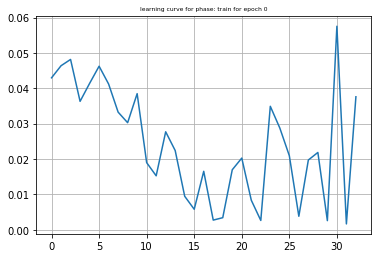

train Loss: 0.0241 
####################################################


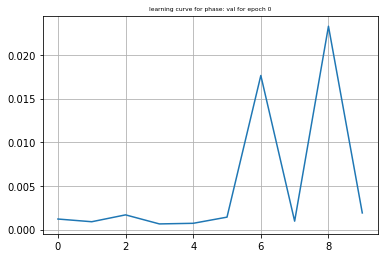

val Loss: 0.0054 
####################################################


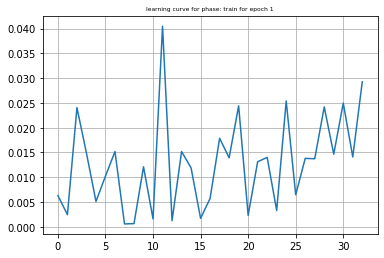

train Loss: 0.0126 
####################################################


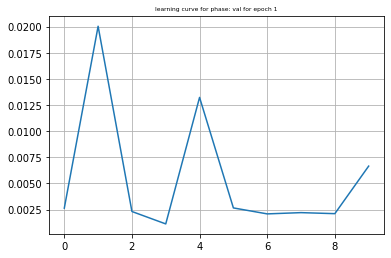

val Loss: 0.0054 
####################################################


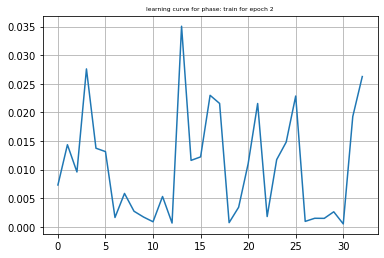

train Loss: 0.0103 
####################################################


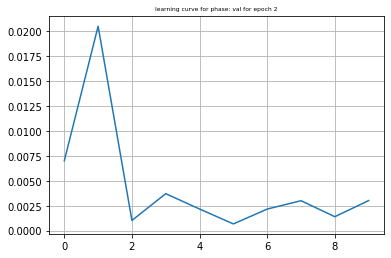

val Loss: 0.0046 
####################################################


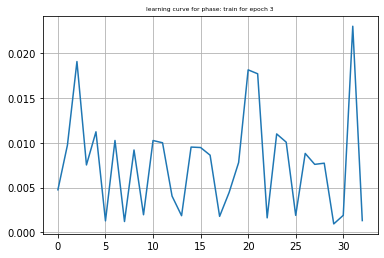

train Loss: 0.0079 
####################################################


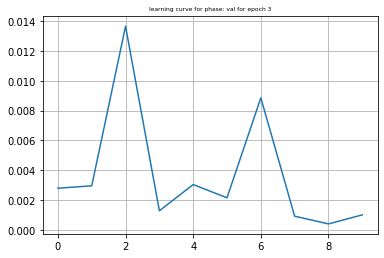

val Loss: 0.0040 
####################################################


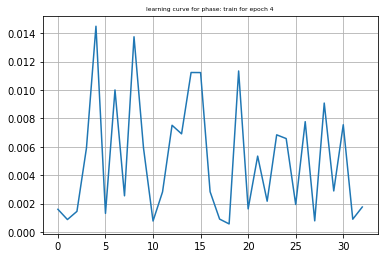

train Loss: 0.0052 
####################################################


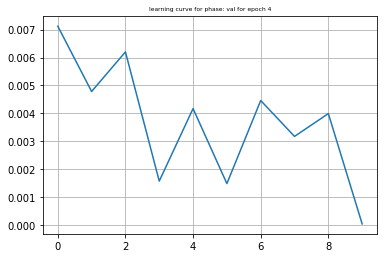

val Loss: 0.0041 
####################################################


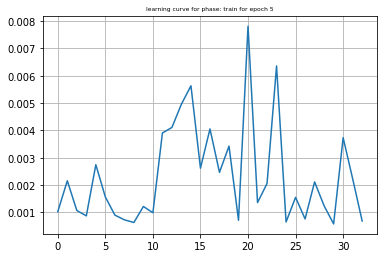

train Loss: 0.0024 
####################################################


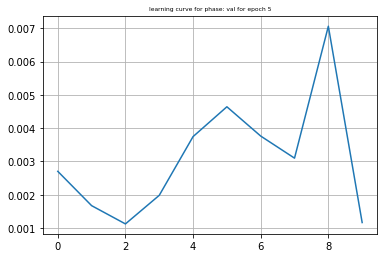

val Loss: 0.0033 
####################################################


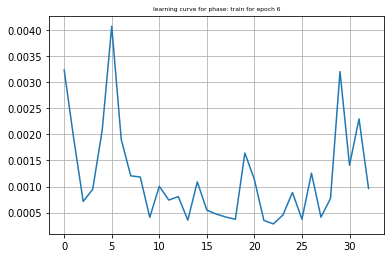

train Loss: 0.0012 
####################################################


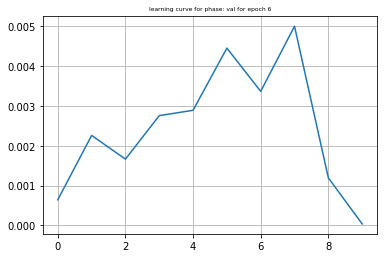

val Loss: 0.0027 
####################################################


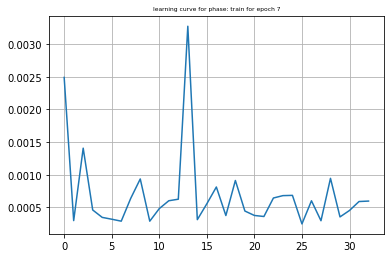

train Loss: 0.0007 
####################################################


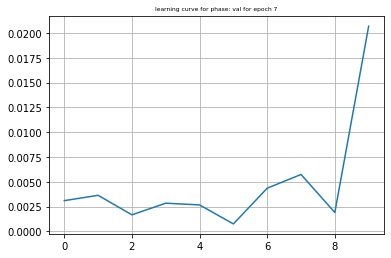

val Loss: 0.0032 
####################################################


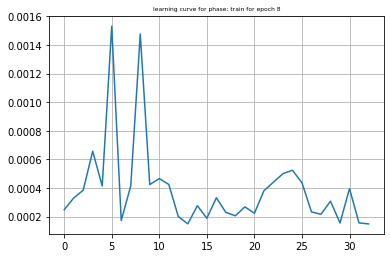

train Loss: 0.0004 
####################################################


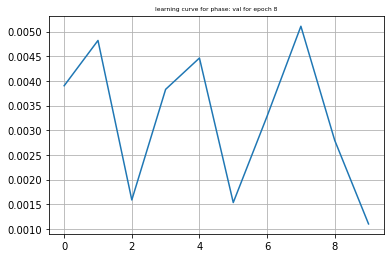

val Loss: 0.0035 
####################################################


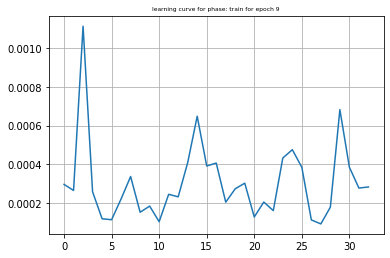

train Loss: 0.0003 
####################################################


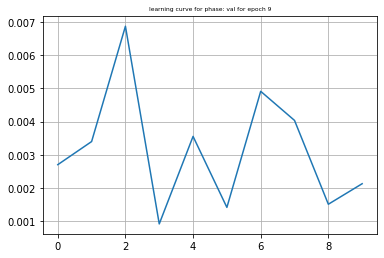

val Loss: 0.0032 
####################################################


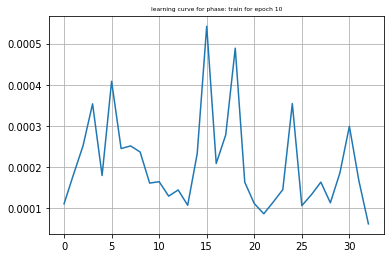

train Loss: 0.0002 
####################################################


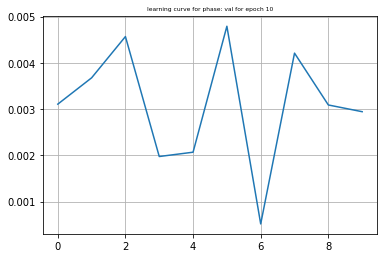

val Loss: 0.0031 
####################################################


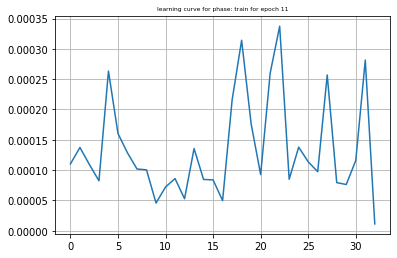

train Loss: 0.0001 
####################################################


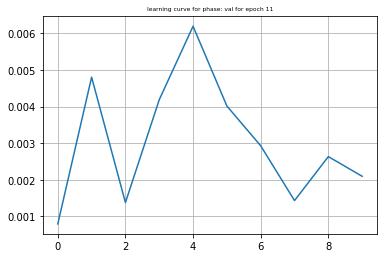

val Loss: 0.0031 
####################################################


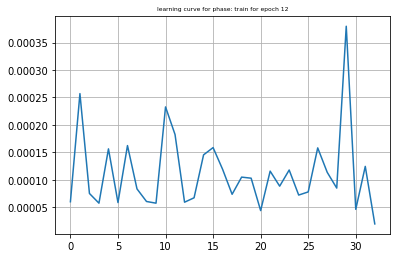

train Loss: 0.0001 
####################################################


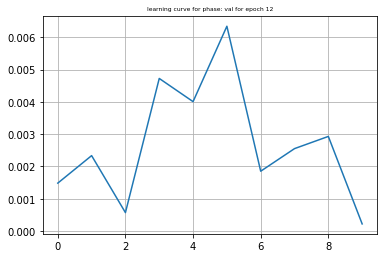

val Loss: 0.0029 
####################################################


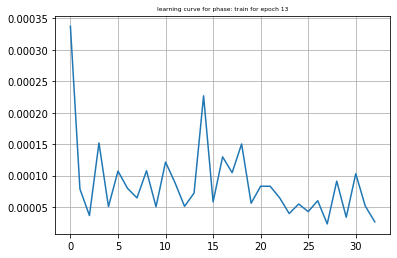

train Loss: 0.0001 
####################################################


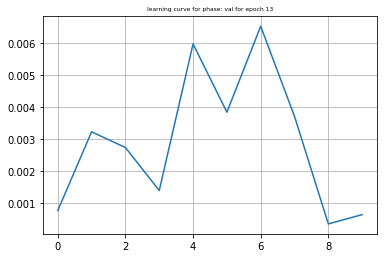

val Loss: 0.0031 
####################################################


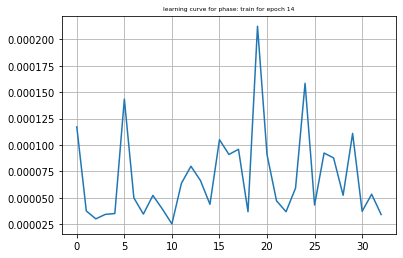

train Loss: 0.0001 
####################################################


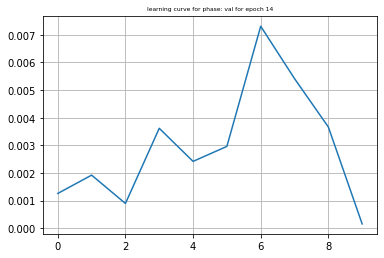

val Loss: 0.0032 
####################################################


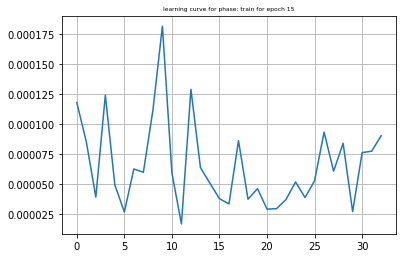

train Loss: 0.0001 
####################################################


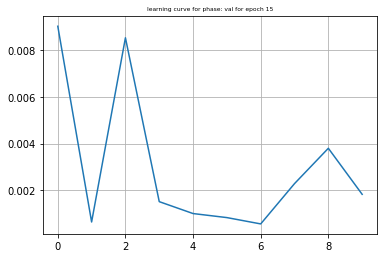

val Loss: 0.0031 
####################################################


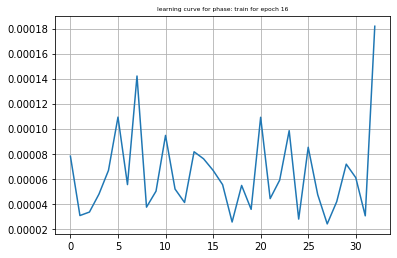

train Loss: 0.0001 
####################################################


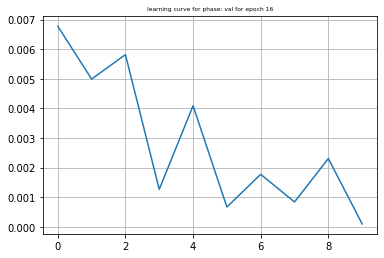

val Loss: 0.0031 
####################################################


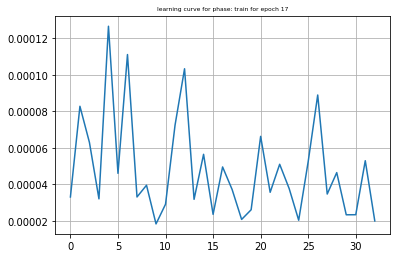

train Loss: 0.0000 
####################################################


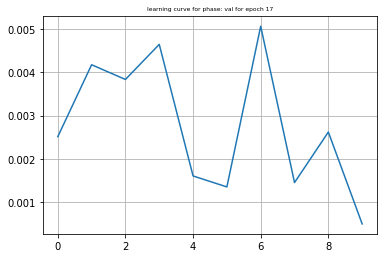

val Loss: 0.0030 
####################################################


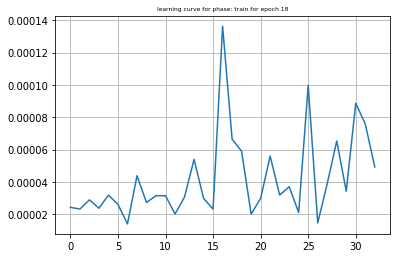

train Loss: 0.0000 
####################################################


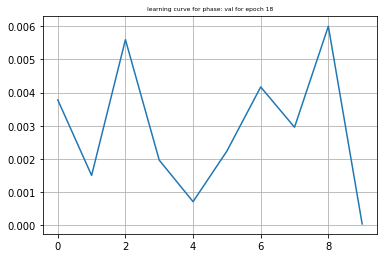

val Loss: 0.0032 
####################################################


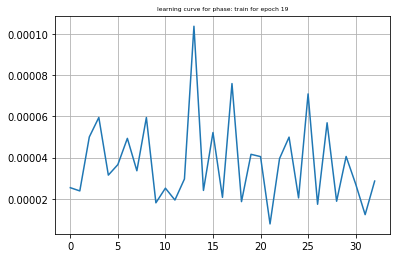

train Loss: 0.0000 
####################################################


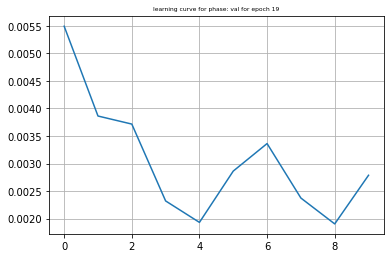

val Loss: 0.0031 
####################################################


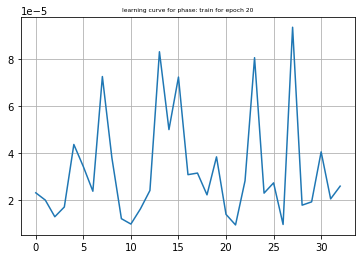

train Loss: 0.0000 
####################################################


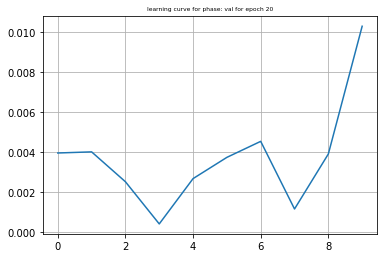

val Loss: 0.0031 
####################################################


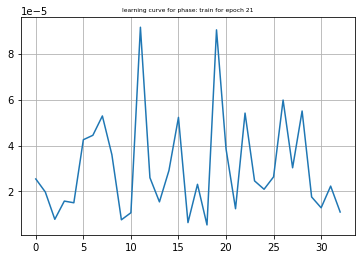

train Loss: 0.0000 
####################################################


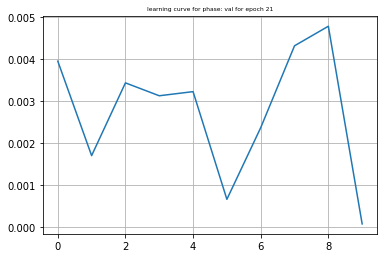

val Loss: 0.0030 
####################################################


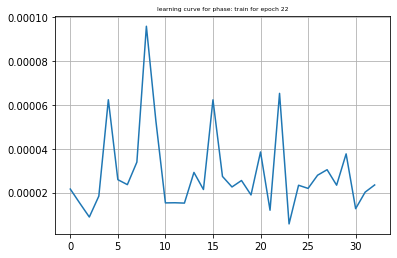

train Loss: 0.0000 
####################################################


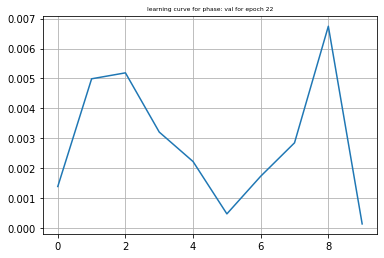

val Loss: 0.0032 
####################################################


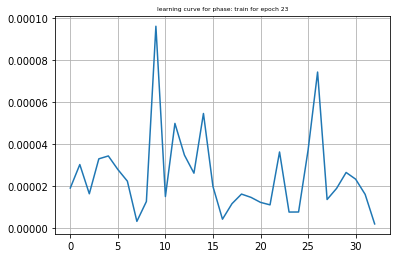

train Loss: 0.0000 
####################################################


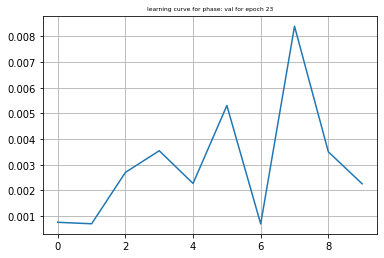

val Loss: 0.0031 
####################################################


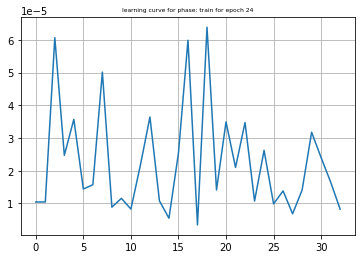

train Loss: 0.0000 
####################################################


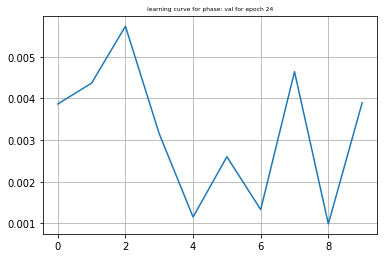

val Loss: 0.0031 
####################################################


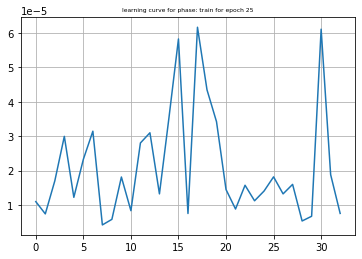

train Loss: 0.0000 
####################################################


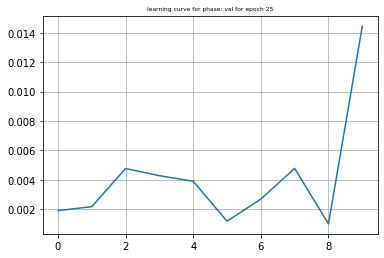

val Loss: 0.0031 
####################################################


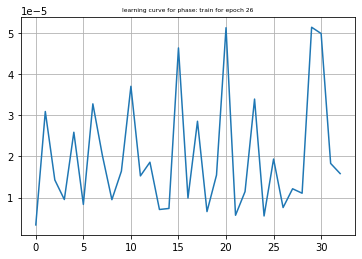

train Loss: 0.0000 
####################################################


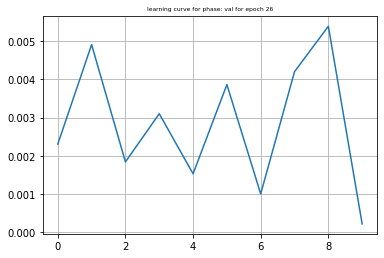

val Loss: 0.0031 
####################################################


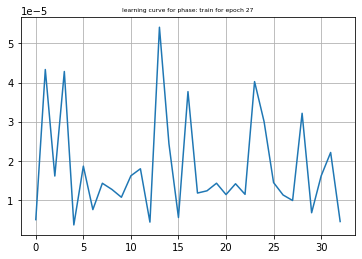

train Loss: 0.0000 
####################################################


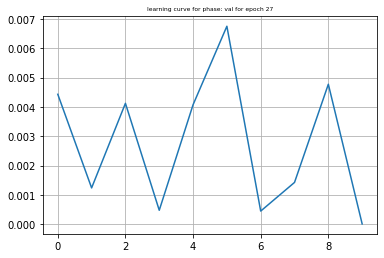

val Loss: 0.0030 
####################################################


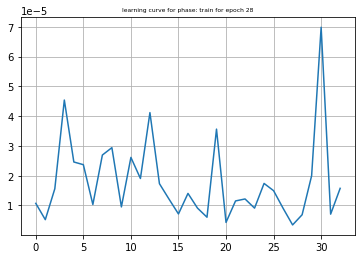

train Loss: 0.0000 
####################################################


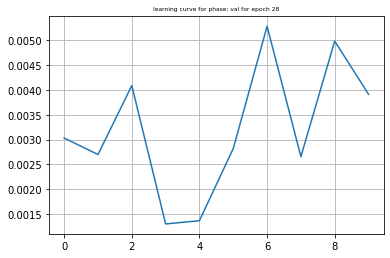

val Loss: 0.0031 
####################################################


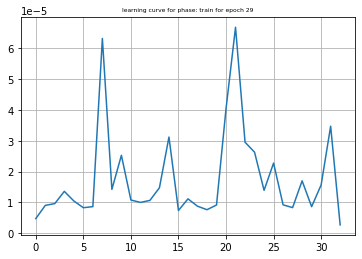

train Loss: 0.0000 
####################################################


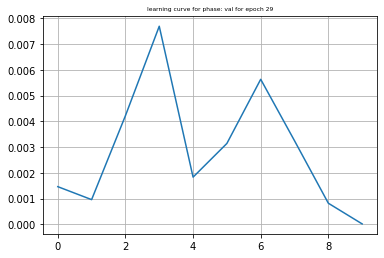

val Loss: 0.0032 
####################################################


In [26]:
model = train_model(out_nat_model, criterion, optimizer, epoch=30)

##  модель для outdoor artificial

In [27]:
out_art_train_dataset = Data(img_train_dir, out_art_train)
out_art_test_dataset = Data(img_test_dir, out_art_test)

In [28]:
train_loader = torch.utils.data.DataLoader(out_art_train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(out_art_test_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [29]:
dataloaders = {
    'train':train_loader, 
    'val': test_loader
}
dataset_sizes = {
    'train':out_nat_train.shape[0],
    'val':out_nat_test.shape[0]
}

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

In [31]:
out_art_model = models.vgg16(pretrained=True)
out_art_model.classifier = nn.Sequential(
            nn.Linear(25088, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Softmax()
            )

In [32]:
out_art_model = out_art_model.to(device)

In [33]:
optimizer = optim.SGD(out_art_model.parameters(), lr=0.001, momentum=0.95)
criterion = illumination_loss

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


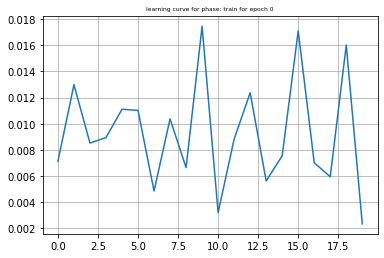

train Loss: 0.0182 
####################################################


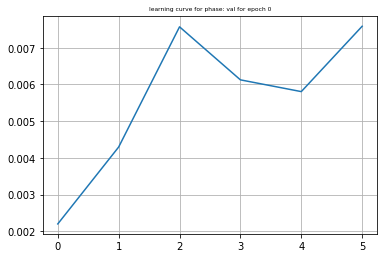

val Loss: 0.0099 
####################################################


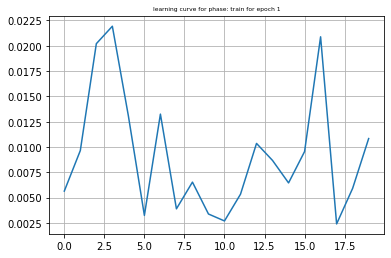

train Loss: 0.0177 
####################################################


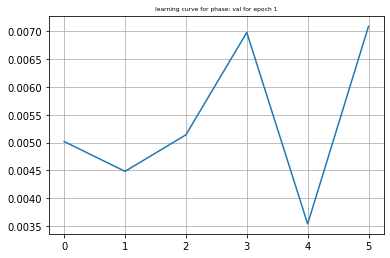

val Loss: 0.0096 
####################################################


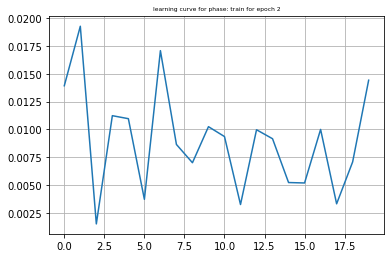

train Loss: 0.0172 
####################################################


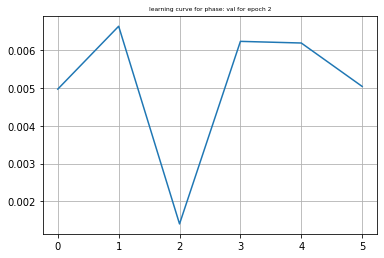

val Loss: 0.0094 
####################################################


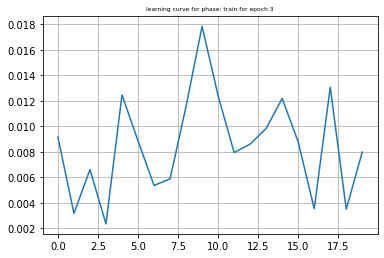

train Loss: 0.0165 
####################################################


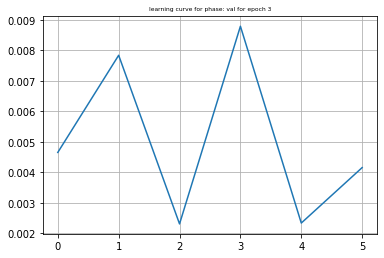

val Loss: 0.0095 
####################################################


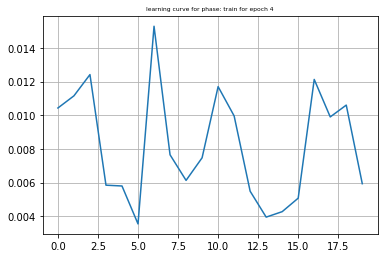

train Loss: 0.0160 
####################################################


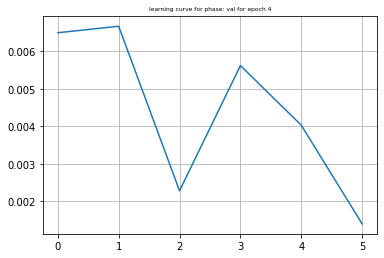

val Loss: 0.0090 
####################################################


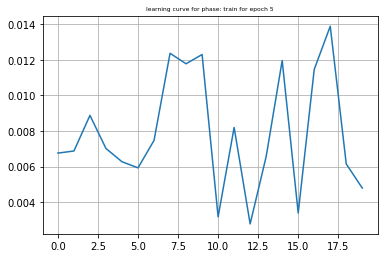

train Loss: 0.0154 
####################################################


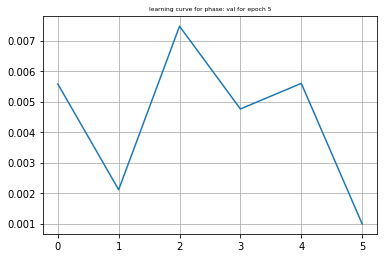

val Loss: 0.0091 
####################################################


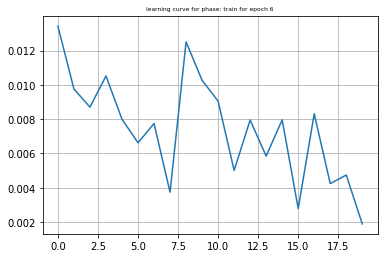

train Loss: 0.0146 
####################################################


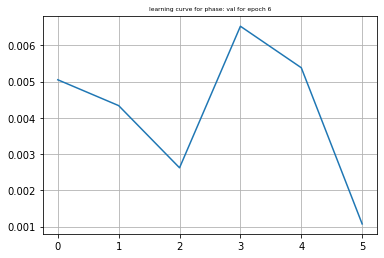

val Loss: 0.0085 
####################################################


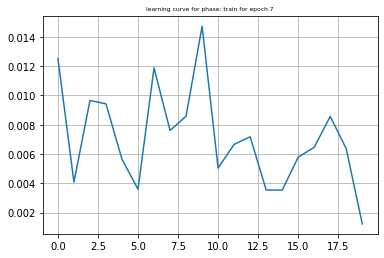

train Loss: 0.0140 
####################################################


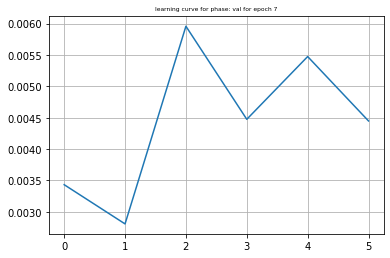

val Loss: 0.0082 
####################################################


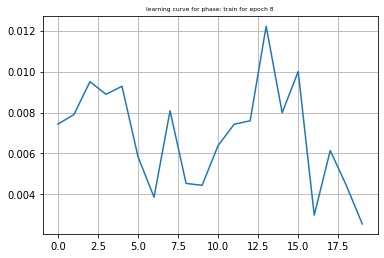

train Loss: 0.0135 
####################################################


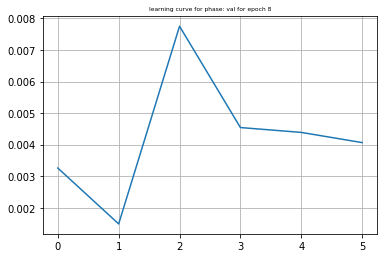

val Loss: 0.0079 
####################################################


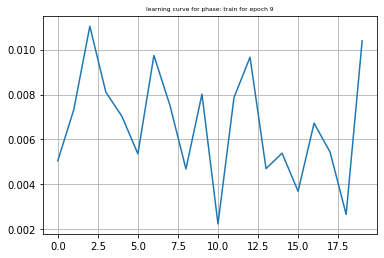

train Loss: 0.0127 
####################################################


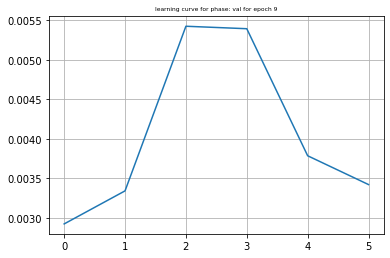

val Loss: 0.0077 
####################################################


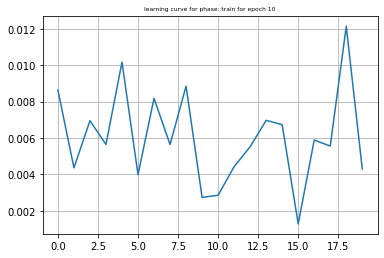

train Loss: 0.0117 
####################################################


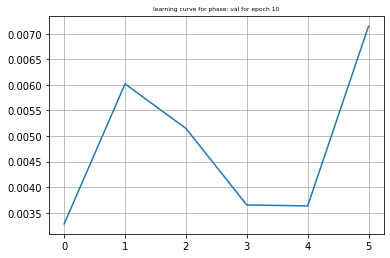

val Loss: 0.0084 
####################################################


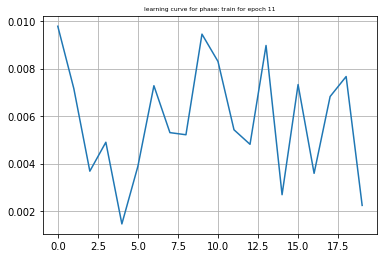

train Loss: 0.0114 
####################################################


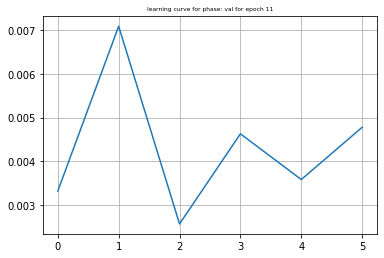

val Loss: 0.0079 
####################################################


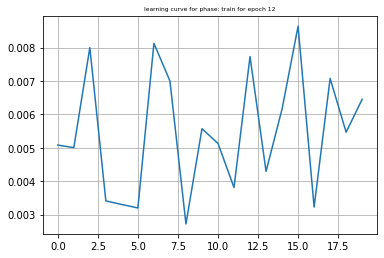

train Loss: 0.0105 
####################################################


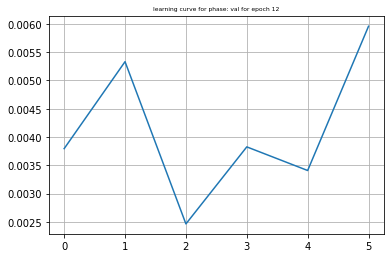

val Loss: 0.0072 
####################################################


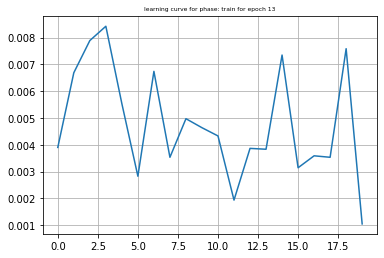

train Loss: 0.0094 
####################################################


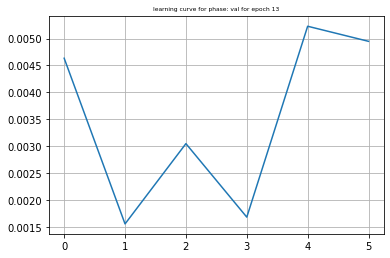

val Loss: 0.0062 
####################################################


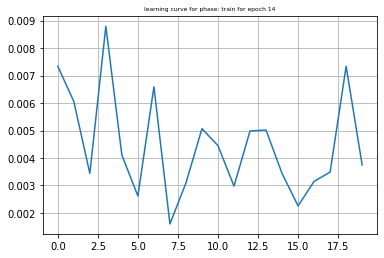

train Loss: 0.0087 
####################################################


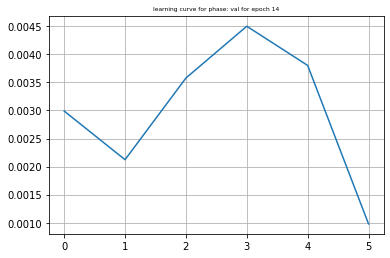

val Loss: 0.0061 
####################################################


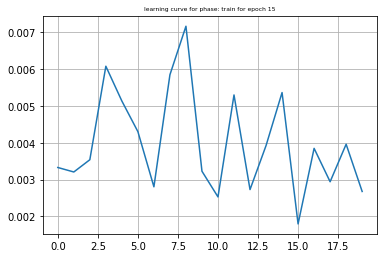

train Loss: 0.0078 
####################################################


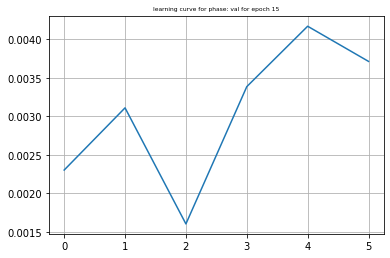

val Loss: 0.0055 
####################################################


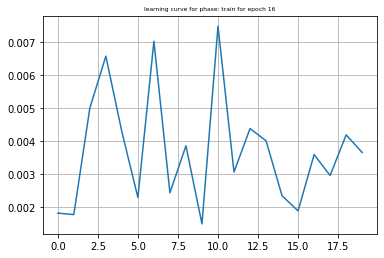

train Loss: 0.0072 
####################################################


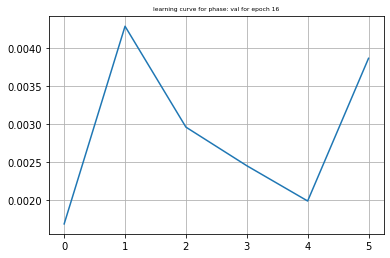

val Loss: 0.0051 
####################################################


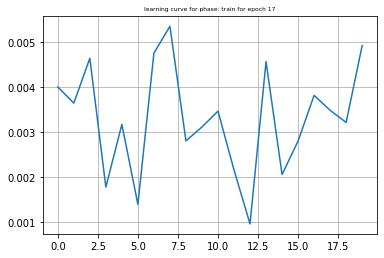

train Loss: 0.0063 
####################################################


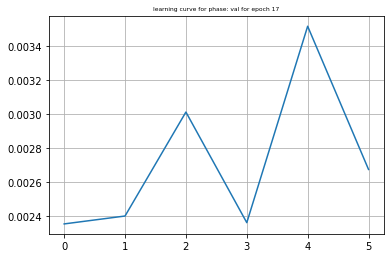

val Loss: 0.0051 
####################################################


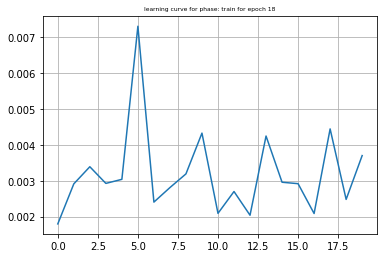

train Loss: 0.0061 
####################################################


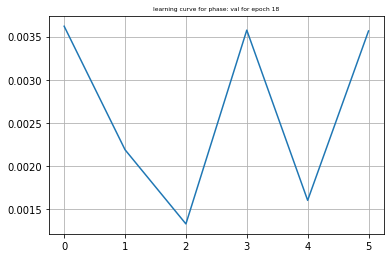

val Loss: 0.0047 
####################################################


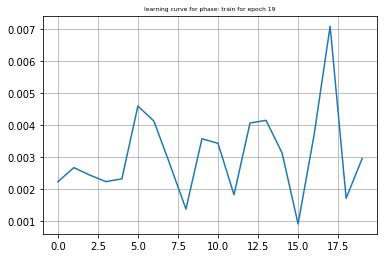

train Loss: 0.0059 
####################################################


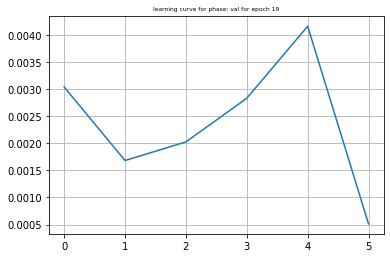

val Loss: 0.0049 
####################################################


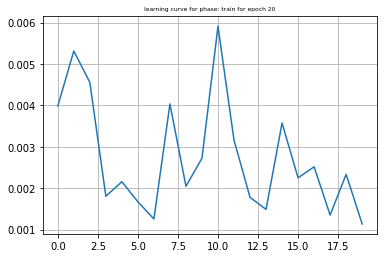

train Loss: 0.0054 
####################################################


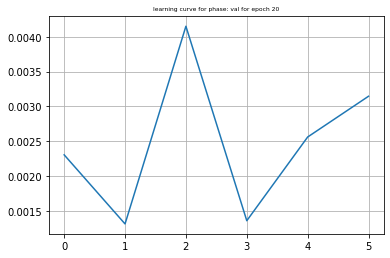

val Loss: 0.0044 
####################################################


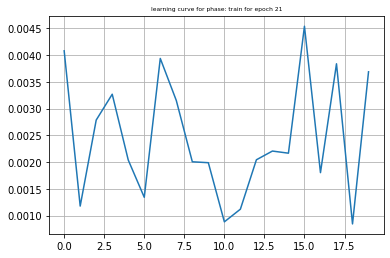

train Loss: 0.0047 
####################################################


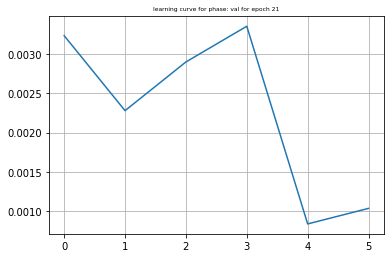

val Loss: 0.0045 
####################################################


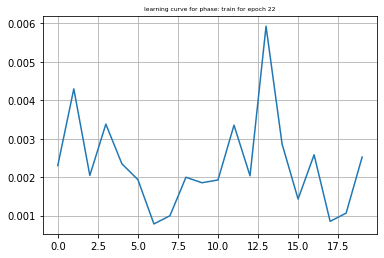

train Loss: 0.0045 
####################################################


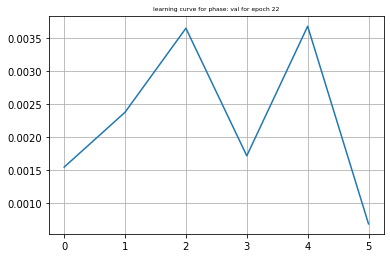

val Loss: 0.0046 
####################################################


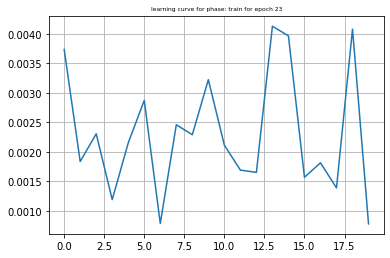

train Loss: 0.0045 
####################################################


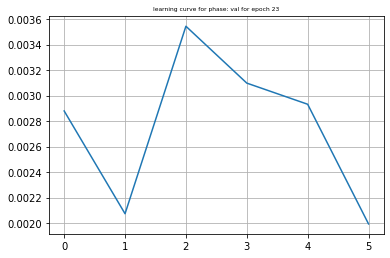

val Loss: 0.0053 
####################################################


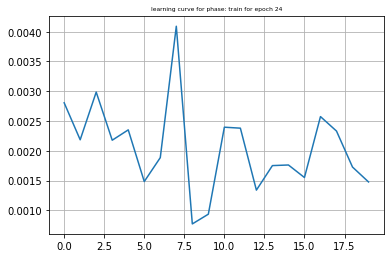

train Loss: 0.0040 
####################################################


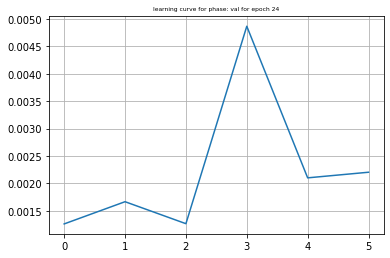

val Loss: 0.0041 
####################################################


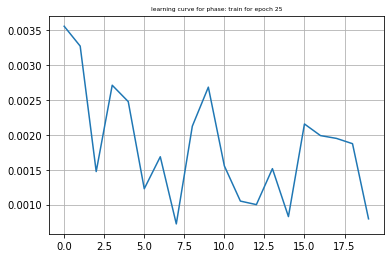

train Loss: 0.0036 
####################################################


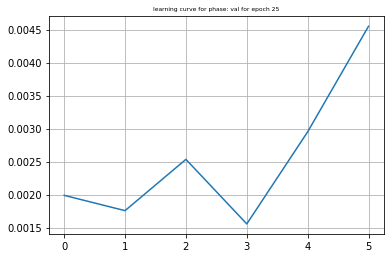

val Loss: 0.0042 
####################################################


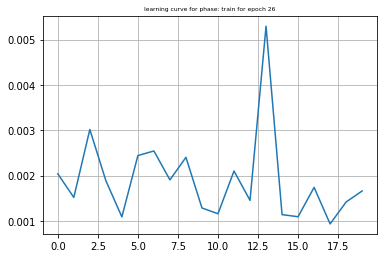

train Loss: 0.0037 
####################################################


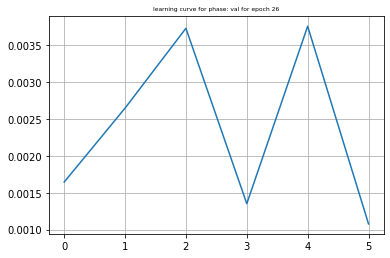

val Loss: 0.0047 
####################################################


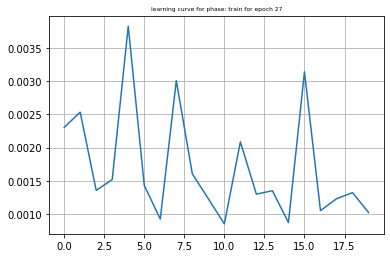

train Loss: 0.0033 
####################################################


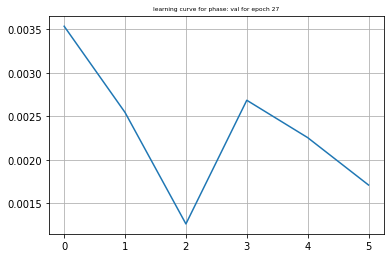

val Loss: 0.0045 
####################################################


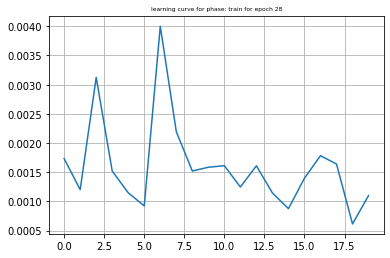

train Loss: 0.0031 
####################################################


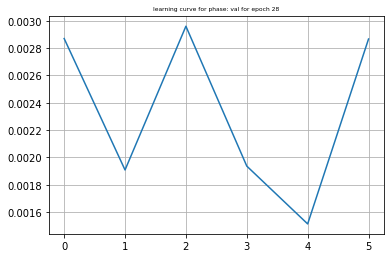

val Loss: 0.0042 
####################################################


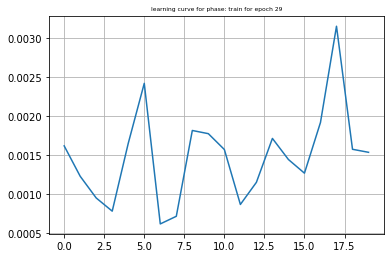

train Loss: 0.0029 
####################################################


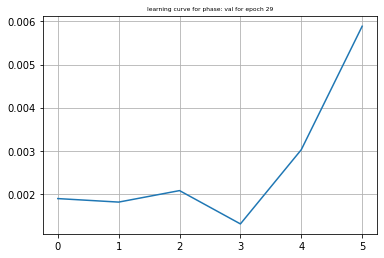

val Loss: 0.0041 
####################################################


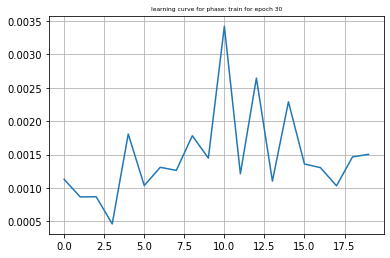

train Loss: 0.0028 
####################################################


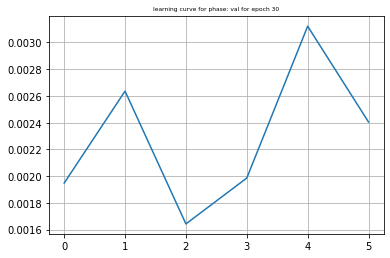

val Loss: 0.0042 
####################################################


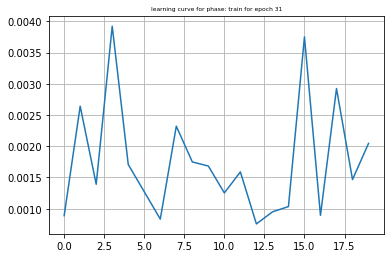

train Loss: 0.0034 
####################################################


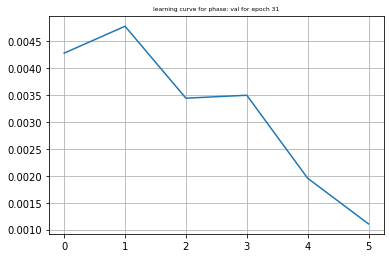

val Loss: 0.0064 
####################################################


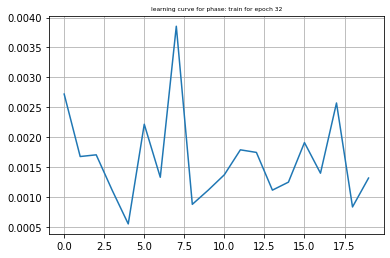

train Loss: 0.0032 
####################################################


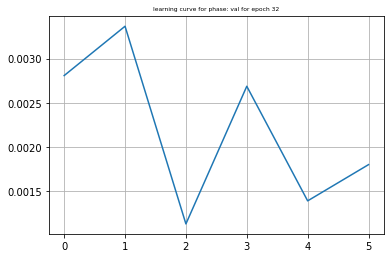

val Loss: 0.0042 
####################################################


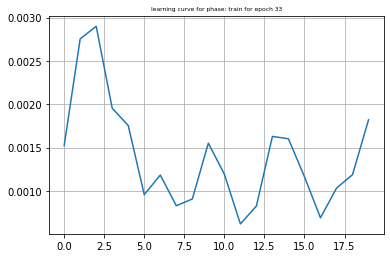

train Loss: 0.0027 
####################################################


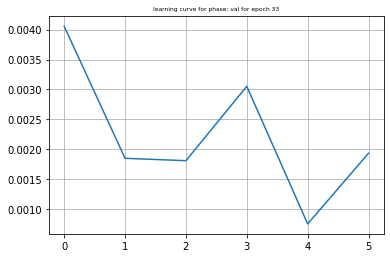

val Loss: 0.0042 
####################################################


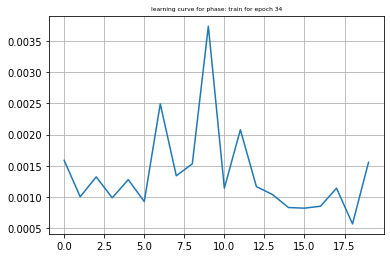

train Loss: 0.0026 
####################################################


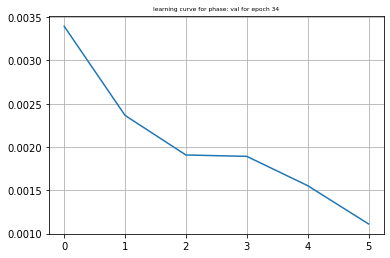

val Loss: 0.0040 
####################################################


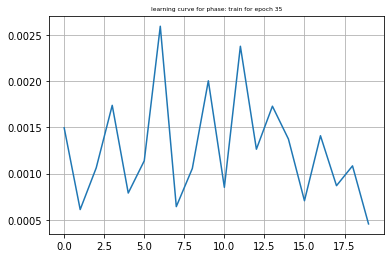

train Loss: 0.0025 
####################################################


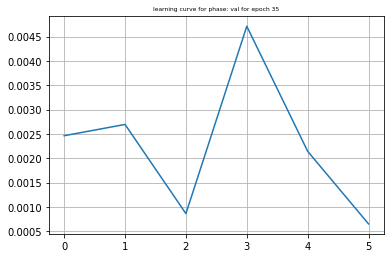

val Loss: 0.0046 
####################################################


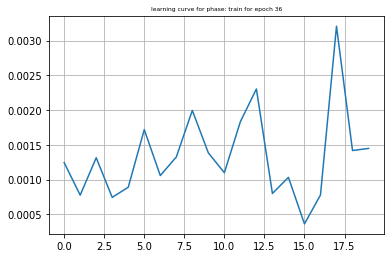

train Loss: 0.0026 
####################################################


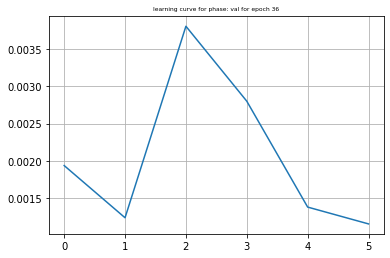

val Loss: 0.0040 
####################################################


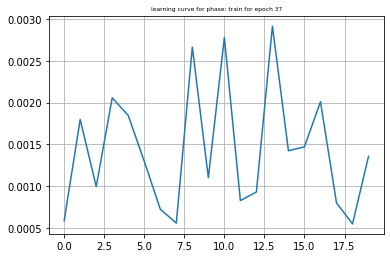

train Loss: 0.0028 
####################################################


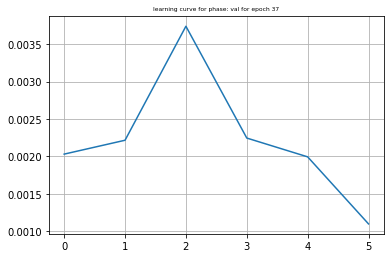

val Loss: 0.0044 
####################################################


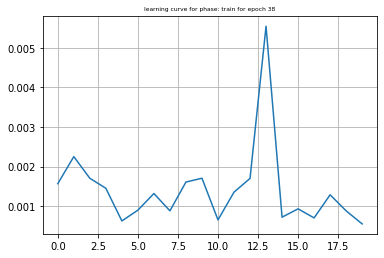

train Loss: 0.0028 
####################################################


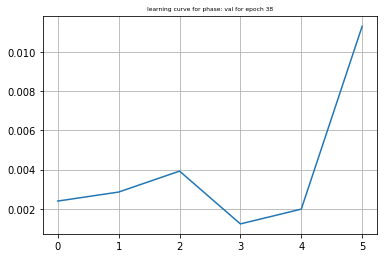

val Loss: 0.0055 
####################################################


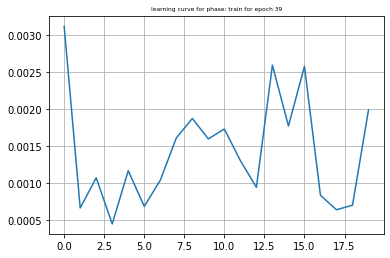

train Loss: 0.0027 
####################################################


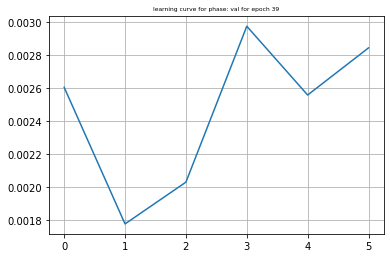

val Loss: 0.0045 
####################################################


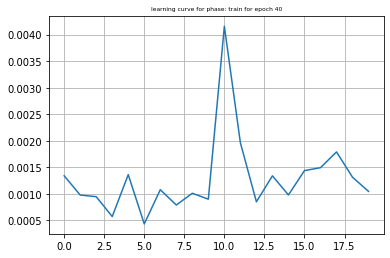

train Loss: 0.0025 
####################################################


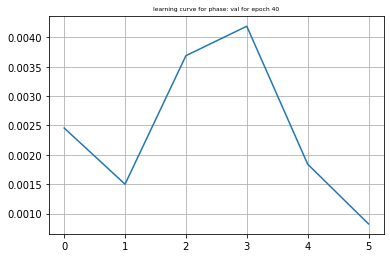

val Loss: 0.0049 
####################################################


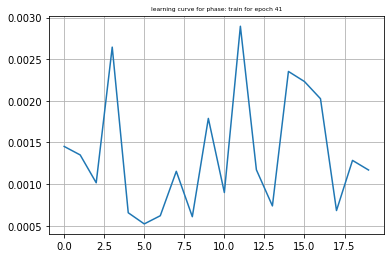

train Loss: 0.0026 
####################################################


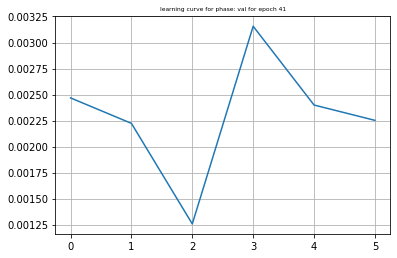

val Loss: 0.0043 
####################################################


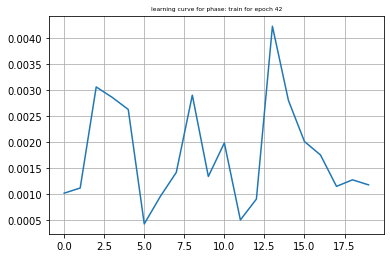

train Loss: 0.0035 
####################################################


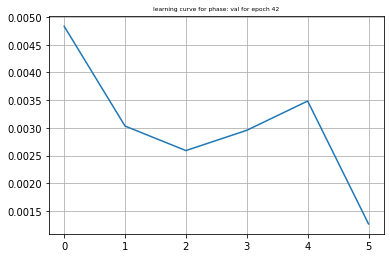

val Loss: 0.0061 
####################################################


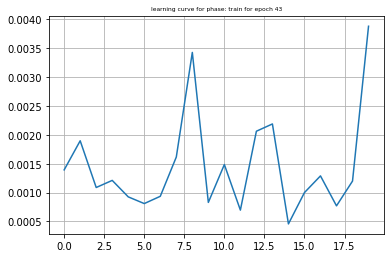

train Loss: 0.0027 
####################################################


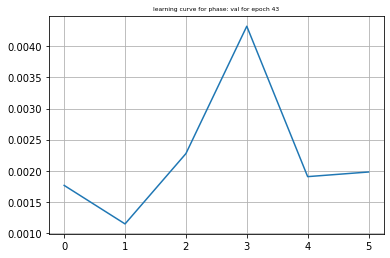

val Loss: 0.0042 
####################################################


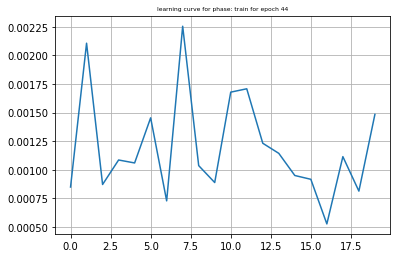

train Loss: 0.0023 
####################################################


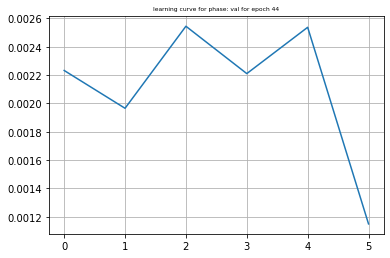

val Loss: 0.0042 
####################################################


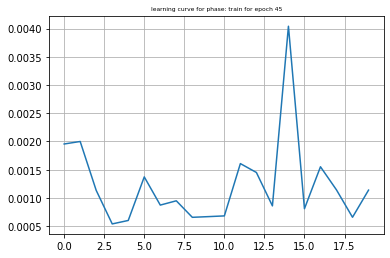

train Loss: 0.0024 
####################################################


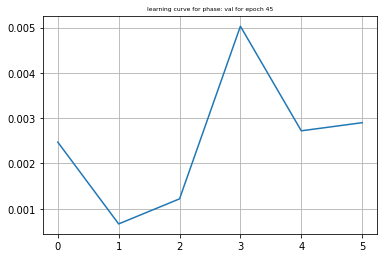

val Loss: 0.0045 
####################################################


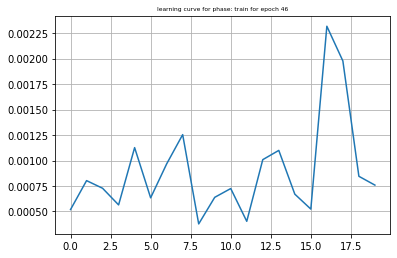

train Loss: 0.0017 
####################################################


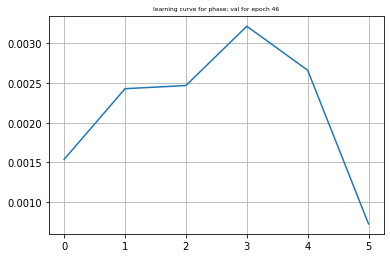

val Loss: 0.0044 
####################################################


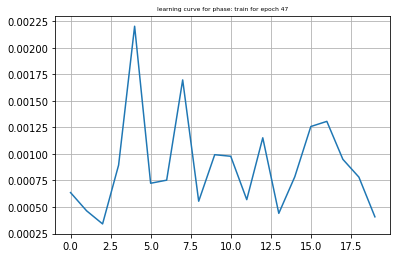

train Loss: 0.0017 
####################################################


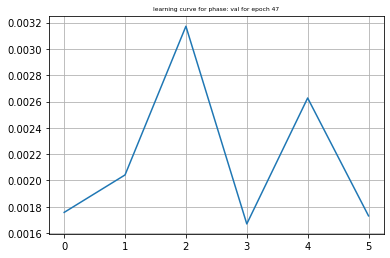

val Loss: 0.0041 
####################################################


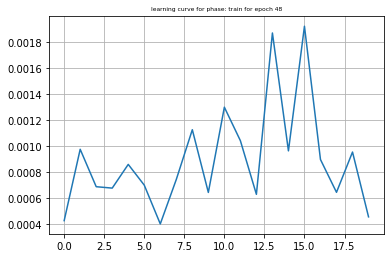

train Loss: 0.0017 
####################################################


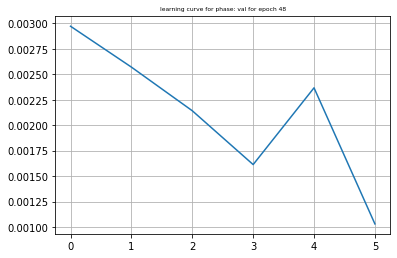

val Loss: 0.0042 
####################################################


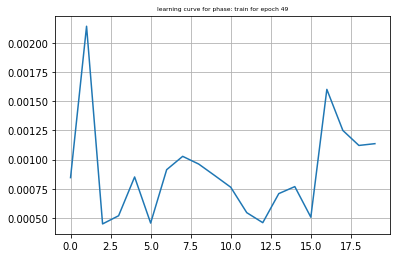

train Loss: 0.0017 
####################################################


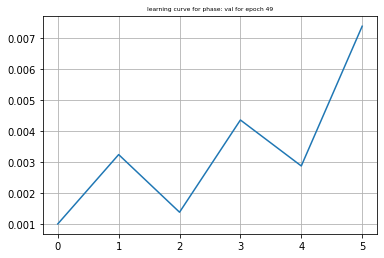

val Loss: 0.0053 
####################################################


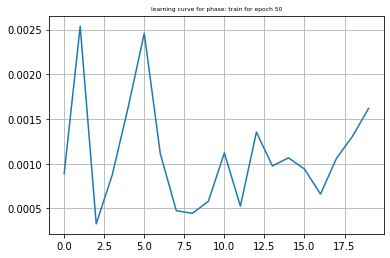

train Loss: 0.0021 
####################################################


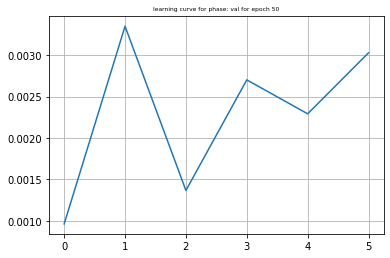

val Loss: 0.0041 
####################################################


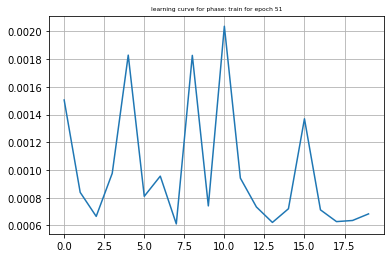

train Loss: 0.0019 
####################################################


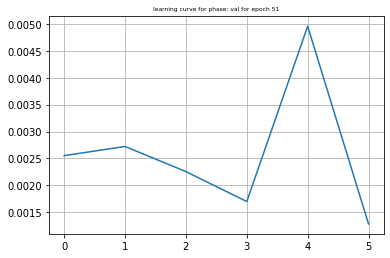

val Loss: 0.0051 
####################################################


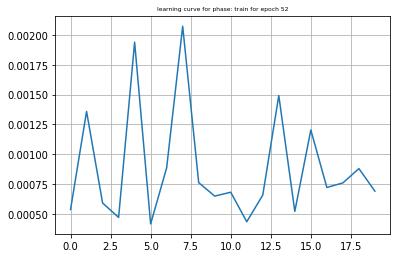

train Loss: 0.0017 
####################################################


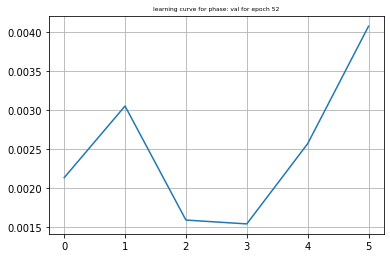

val Loss: 0.0042 
####################################################


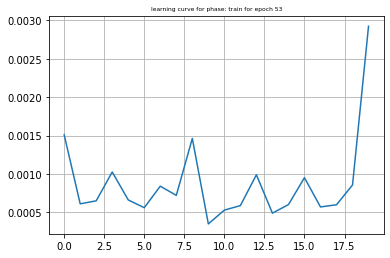

train Loss: 0.0016 
####################################################


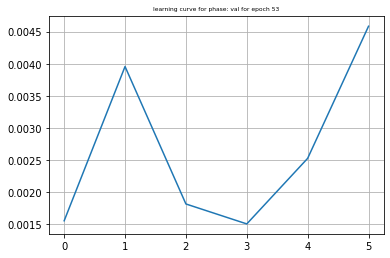

val Loss: 0.0044 
####################################################


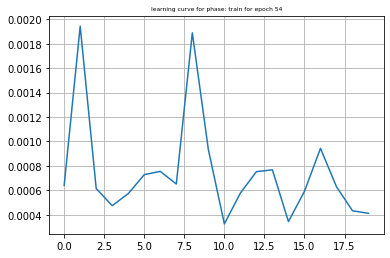

train Loss: 0.0015 
####################################################


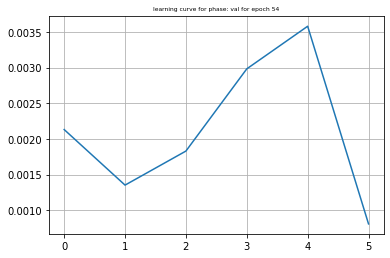

val Loss: 0.0043 
####################################################


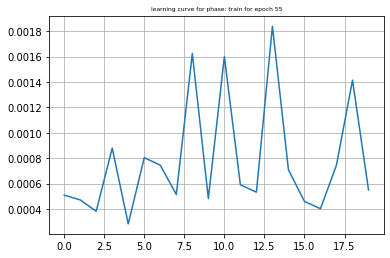

train Loss: 0.0015 
####################################################


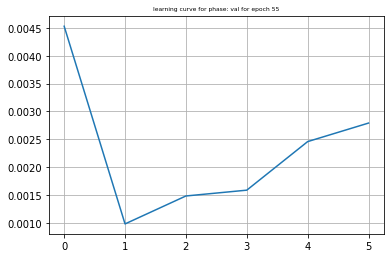

val Loss: 0.0042 
####################################################


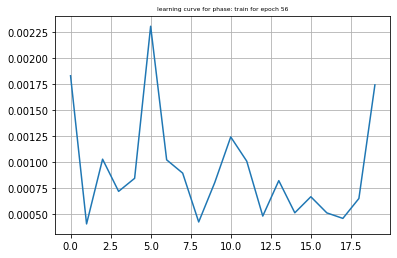

train Loss: 0.0017 
####################################################


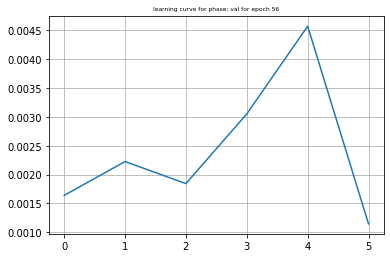

val Loss: 0.0048 
####################################################


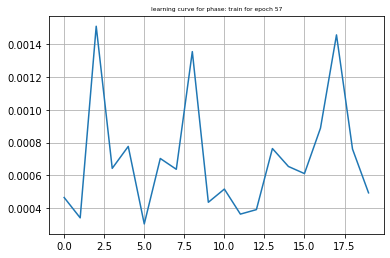

train Loss: 0.0014 
####################################################


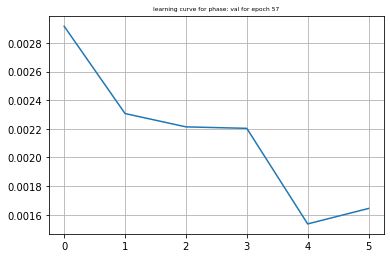

val Loss: 0.0041 
####################################################


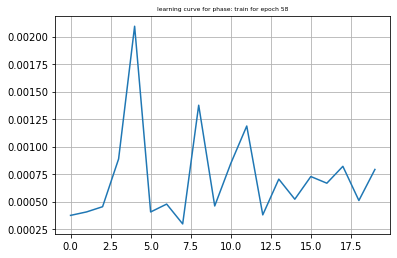

train Loss: 0.0014 
####################################################


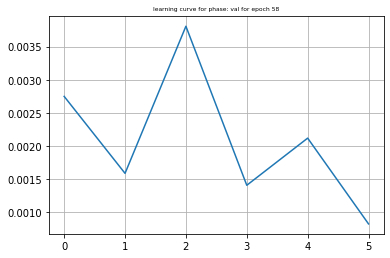

val Loss: 0.0042 
####################################################


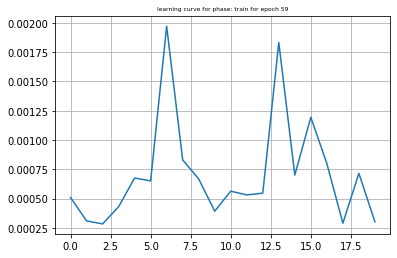

train Loss: 0.0014 
####################################################


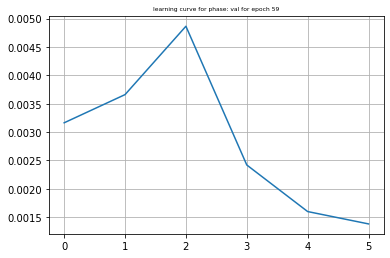

val Loss: 0.0057 
####################################################


In [35]:
model = train_model(out_art_model, criterion, optimizer, epoch=60, dataloaders=dataloaders,  dataset_sizes=dataset_sizes, model_name = f'/content/drive/MyDrive/ТМСС/models/illNet1')

##  модель для indoor artificial

In [36]:
in_art_train_dataset = Data(img_train_dir, in_art_train)
in_art_test_dataset = Data(img_test_dir, in_art_test)

In [37]:
train_loader = torch.utils.data.DataLoader(in_art_train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(in_art_test_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [39]:
dataloaders = {
    'train':train_loader, 
    'val': test_loader
}
dataset_sizes = {
    'train':in_art_train.shape[0],
    'val':in_art_test.shape[0]
}

In [40]:
in_art_model = models.vgg16(pretrained=True)
in_art_model.classifier = nn.Sequential(
            nn.Linear(25088, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Softmax()
            )

In [42]:
in_art_model = in_art_model.to(device)

In [43]:
optimizer = optim.SGD(in_art_model.parameters(), lr=0.001, momentum=0.99)
criterion = illumination_loss

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


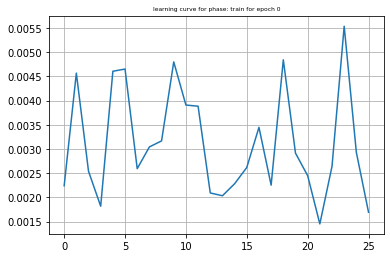

train Loss: 0.0031 
####################################################


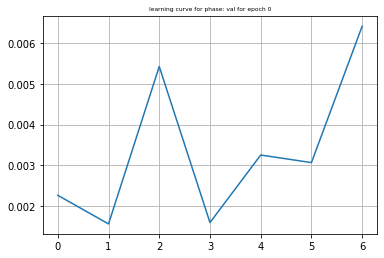

val Loss: 0.0030 
####################################################


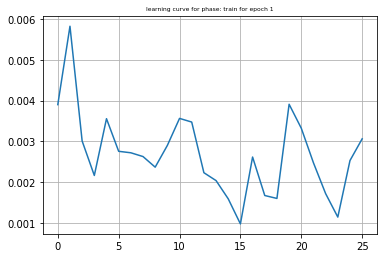

train Loss: 0.0027 
####################################################


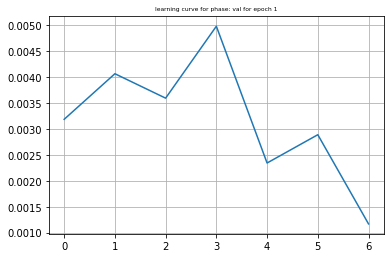

val Loss: 0.0034 
####################################################


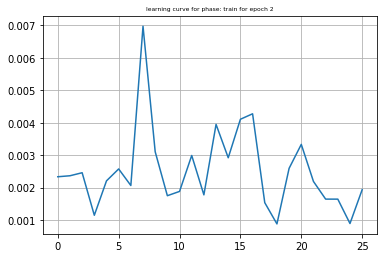

train Loss: 0.0025 
####################################################


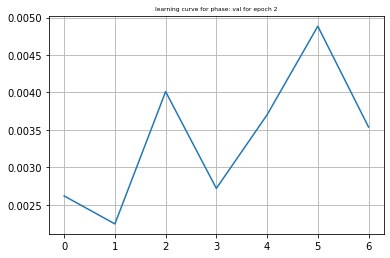

val Loss: 0.0034 
####################################################


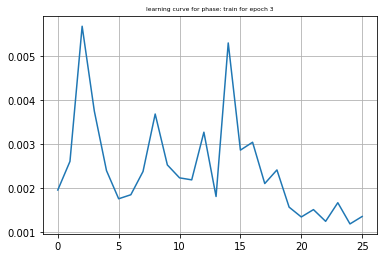

train Loss: 0.0025 
####################################################


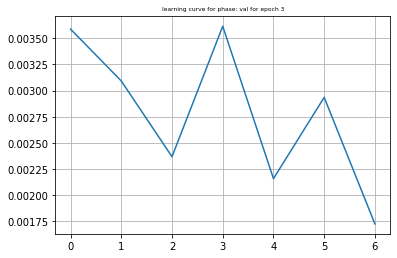

val Loss: 0.0029 
####################################################


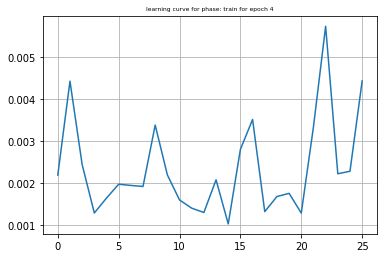

train Loss: 0.0023 
####################################################


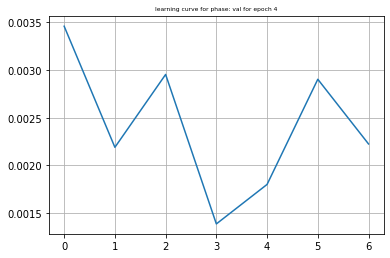

val Loss: 0.0024 
####################################################


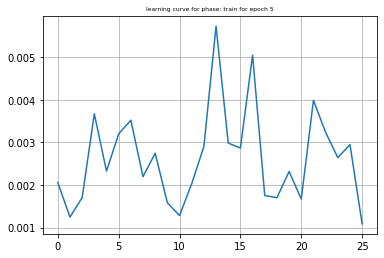

train Loss: 0.0027 
####################################################


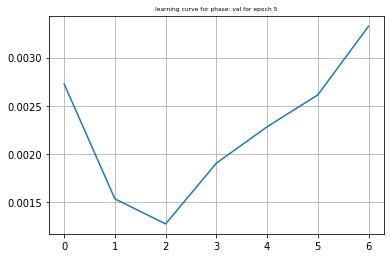

val Loss: 0.0021 
####################################################


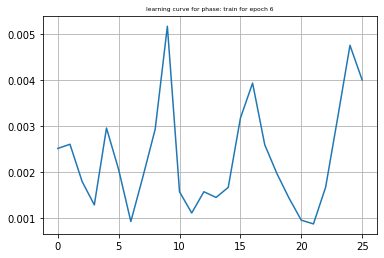

train Loss: 0.0023 
####################################################


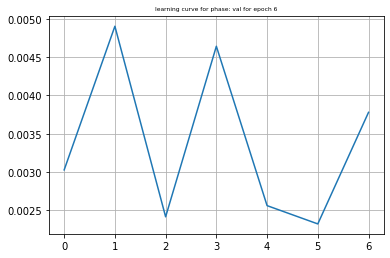

val Loss: 0.0033 
####################################################


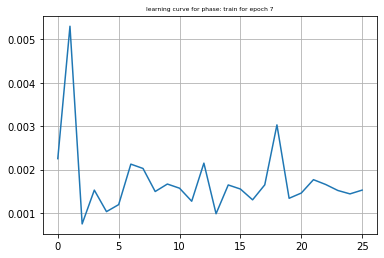

train Loss: 0.0017 
####################################################


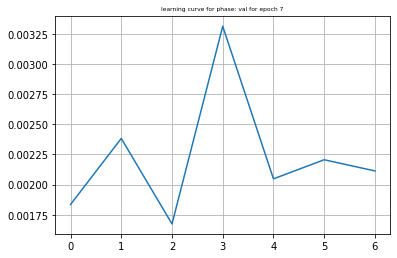

val Loss: 0.0022 
####################################################


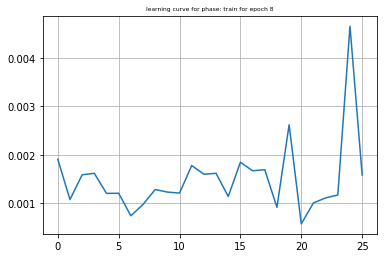

train Loss: 0.0015 
####################################################


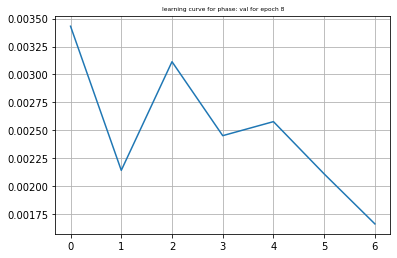

val Loss: 0.0026 
####################################################


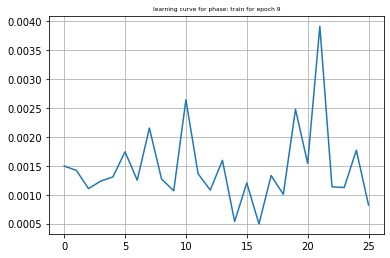

train Loss: 0.0015 
####################################################


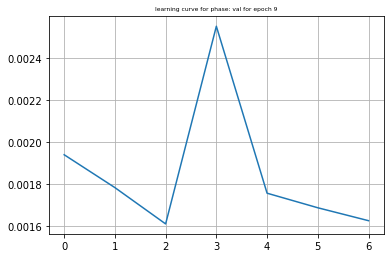

val Loss: 0.0019 
####################################################


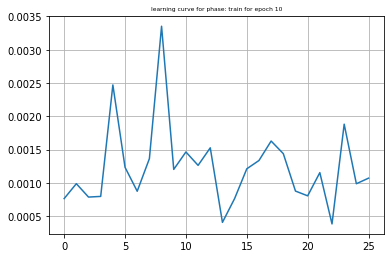

train Loss: 0.0012 
####################################################


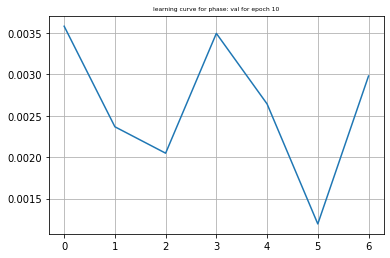

val Loss: 0.0026 
####################################################


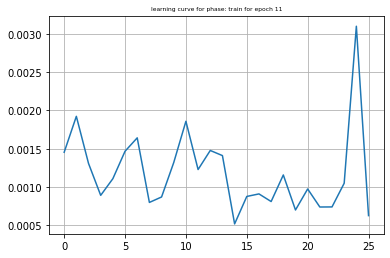

train Loss: 0.0012 
####################################################


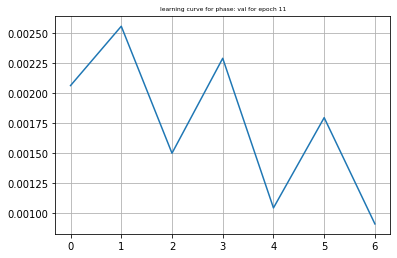

val Loss: 0.0018 
####################################################


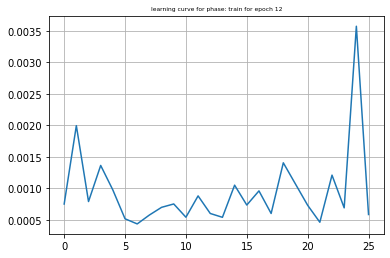

train Loss: 0.0009 
####################################################


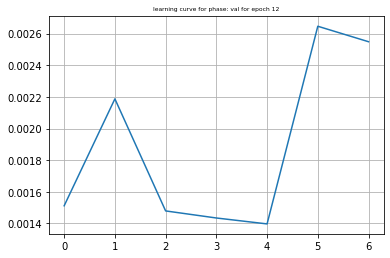

val Loss: 0.0018 
####################################################


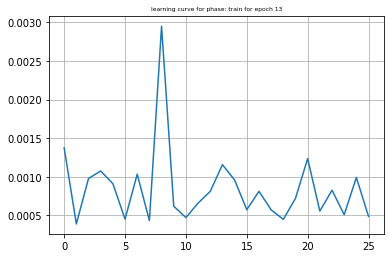

train Loss: 0.0009 
####################################################


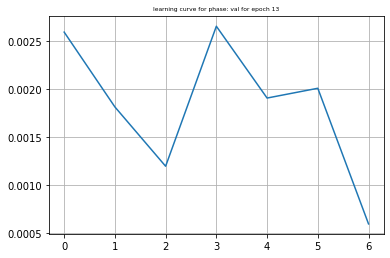

val Loss: 0.0020 
####################################################


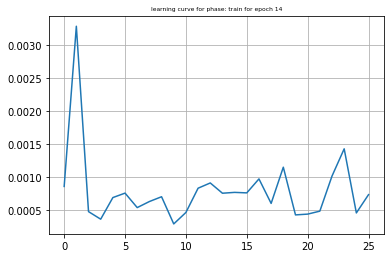

train Loss: 0.0008 
####################################################


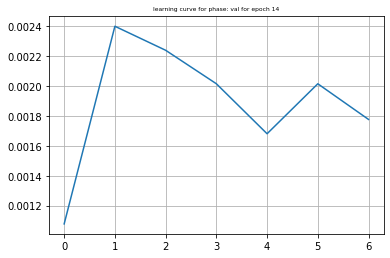

val Loss: 0.0019 
####################################################


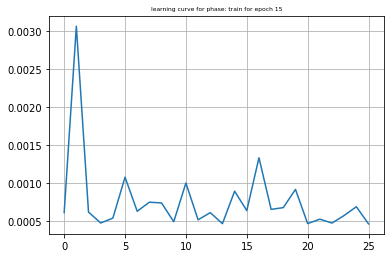

train Loss: 0.0008 
####################################################


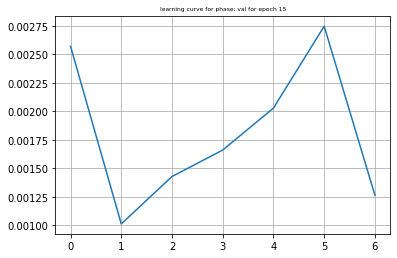

val Loss: 0.0019 
####################################################


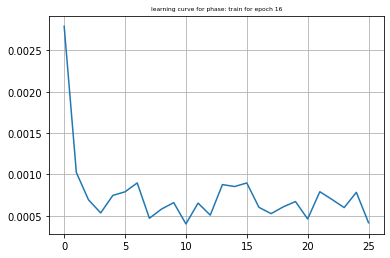

train Loss: 0.0008 
####################################################


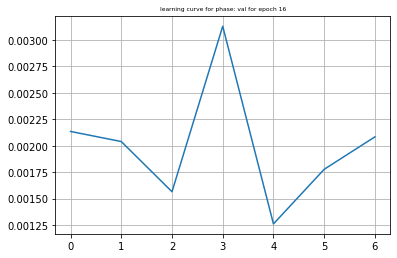

val Loss: 0.0020 
####################################################


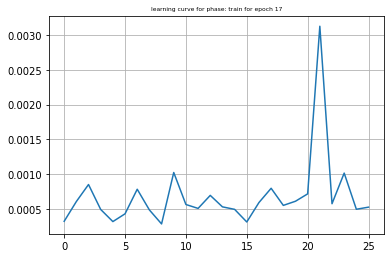

train Loss: 0.0007 
####################################################


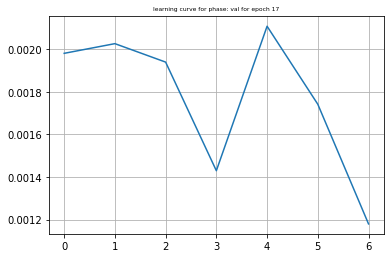

val Loss: 0.0018 
####################################################


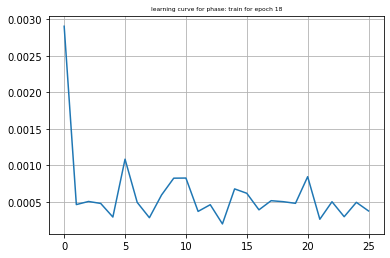

train Loss: 0.0006 
####################################################


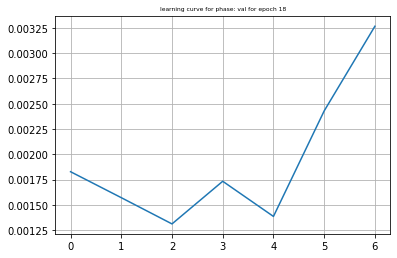

val Loss: 0.0018 
####################################################


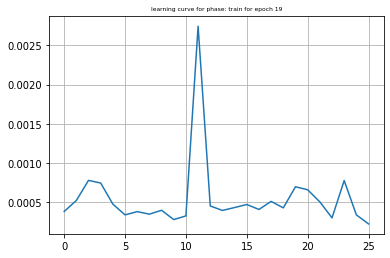

train Loss: 0.0006 
####################################################


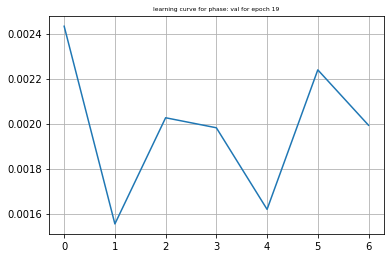

val Loss: 0.0020 
####################################################


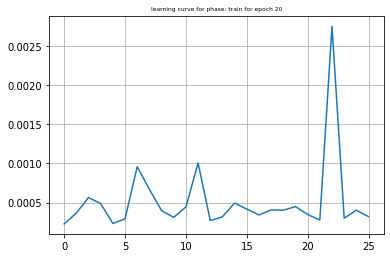

train Loss: 0.0005 
####################################################


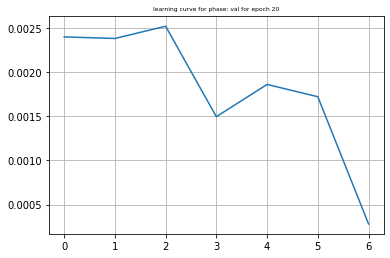

val Loss: 0.0020 
####################################################


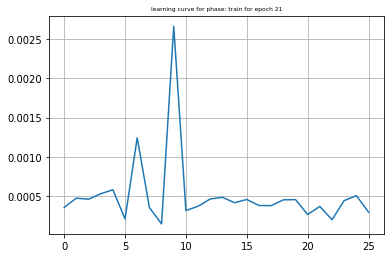

train Loss: 0.0005 
####################################################


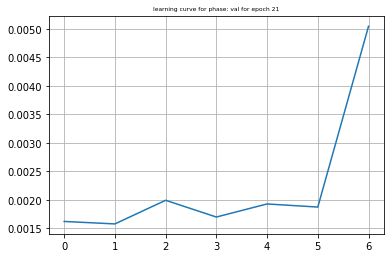

val Loss: 0.0019 
####################################################


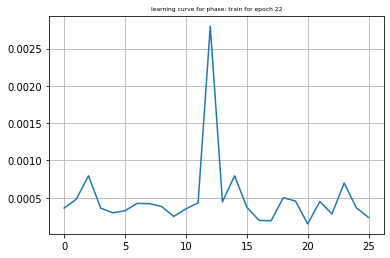

train Loss: 0.0005 
####################################################


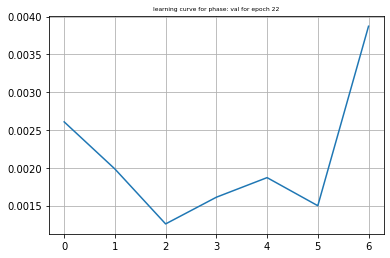

val Loss: 0.0019 
####################################################


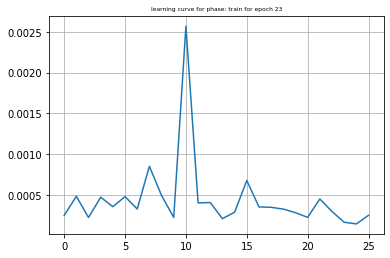

train Loss: 0.0004 
####################################################


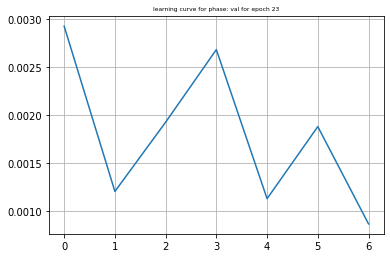

val Loss: 0.0019 
####################################################


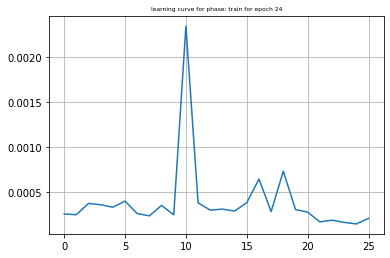

train Loss: 0.0004 
####################################################


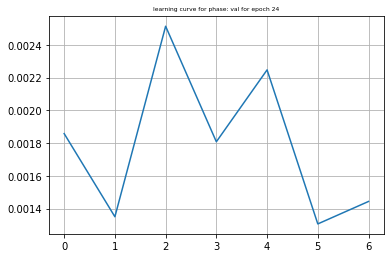

val Loss: 0.0018 
####################################################


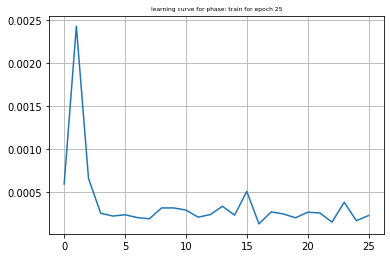

train Loss: 0.0004 
####################################################


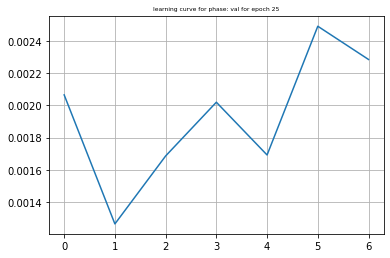

val Loss: 0.0019 
####################################################


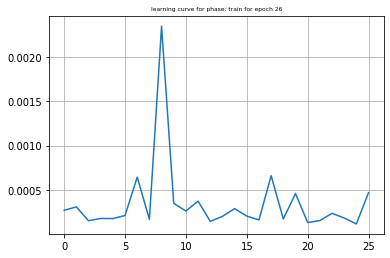

train Loss: 0.0003 
####################################################


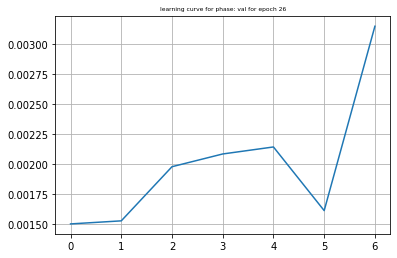

val Loss: 0.0019 
####################################################


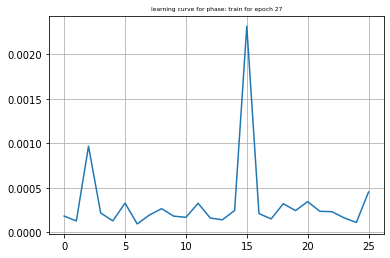

train Loss: 0.0003 
####################################################


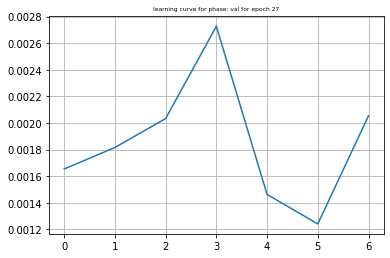

val Loss: 0.0018 
####################################################


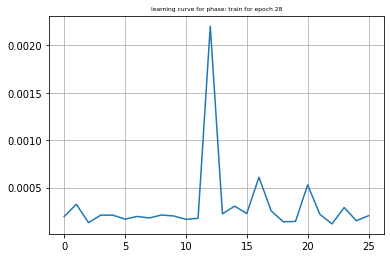

train Loss: 0.0003 
####################################################


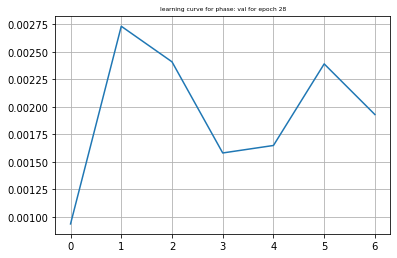

val Loss: 0.0019 
####################################################


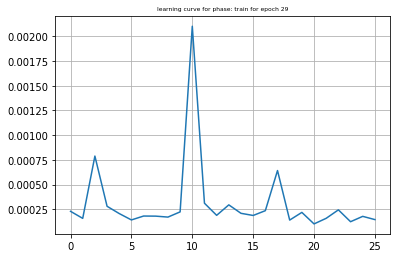

train Loss: 0.0003 
####################################################


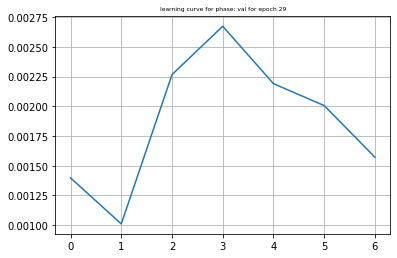

val Loss: 0.0019 
####################################################


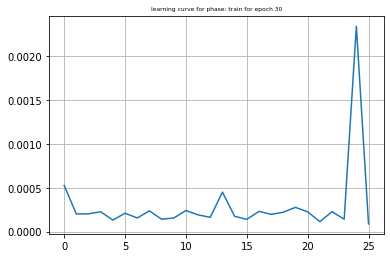

train Loss: 0.0003 
####################################################


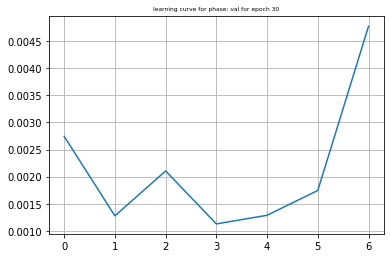

val Loss: 0.0019 
####################################################


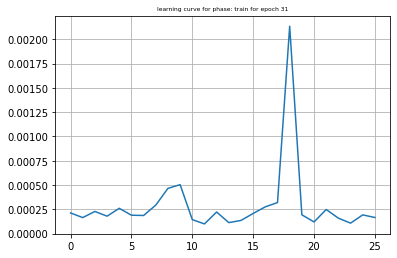

train Loss: 0.0003 
####################################################


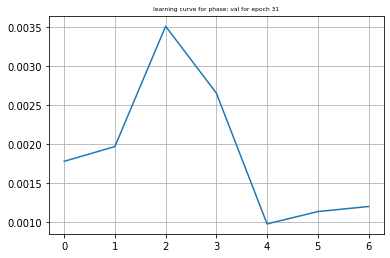

val Loss: 0.0020 
####################################################


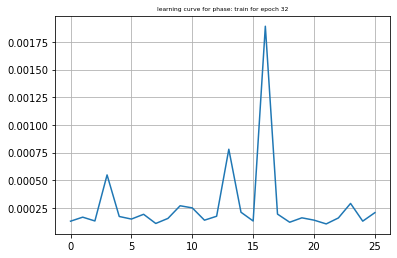

train Loss: 0.0003 
####################################################


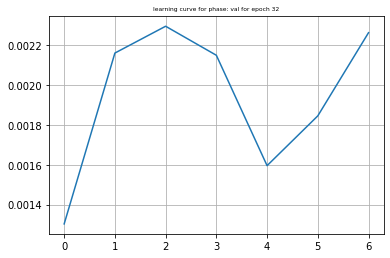

val Loss: 0.0019 
####################################################


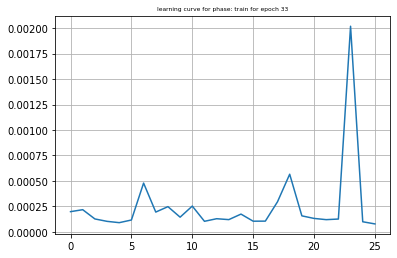

train Loss: 0.0003 
####################################################


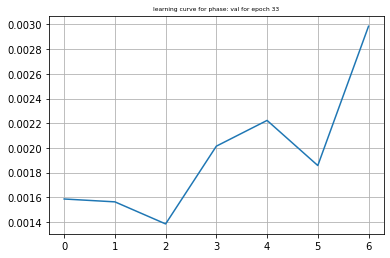

val Loss: 0.0018 
####################################################


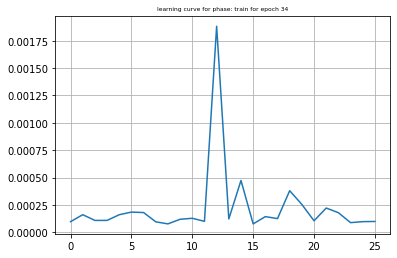

train Loss: 0.0002 
####################################################


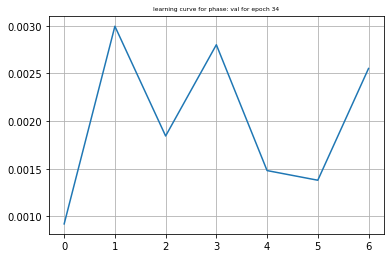

val Loss: 0.0019 
####################################################


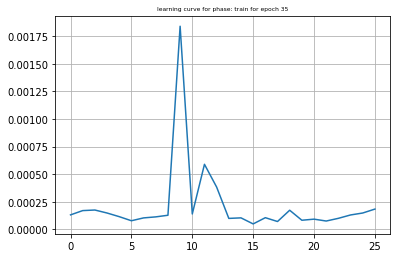

train Loss: 0.0002 
####################################################


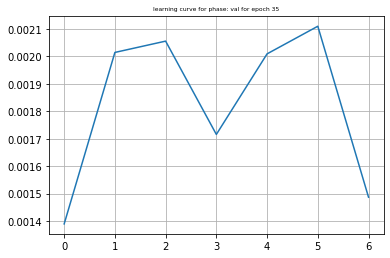

val Loss: 0.0019 
####################################################


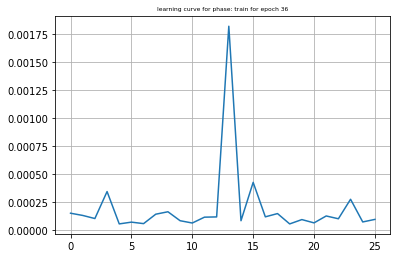

train Loss: 0.0002 
####################################################


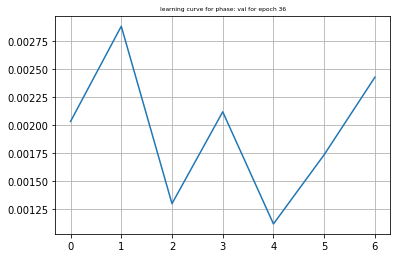

val Loss: 0.0019 
####################################################


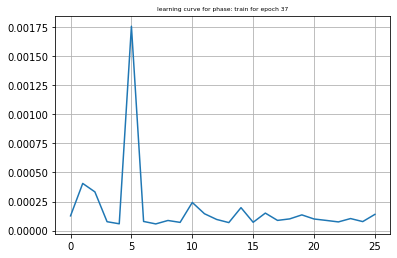

train Loss: 0.0002 
####################################################


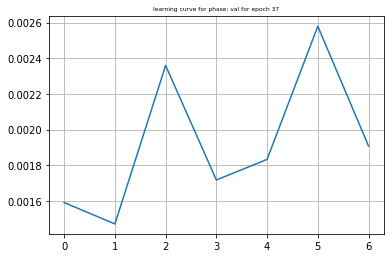

val Loss: 0.0019 
####################################################


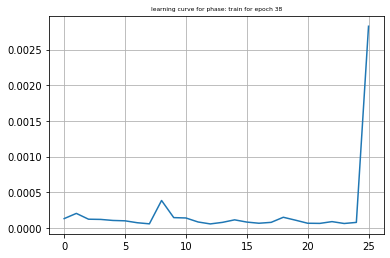

train Loss: 0.0002 
####################################################


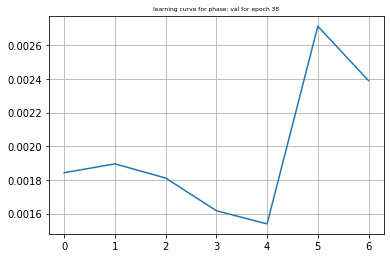

val Loss: 0.0019 
####################################################


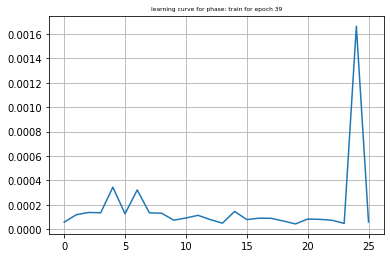

train Loss: 0.0002 
####################################################


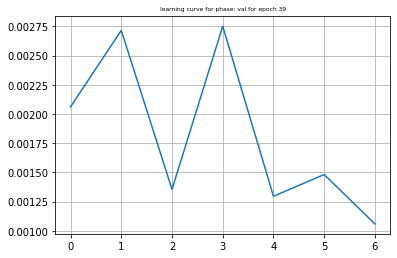

val Loss: 0.0019 
####################################################


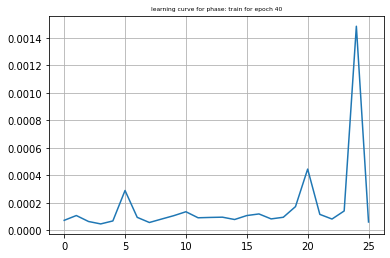

train Loss: 0.0002 
####################################################


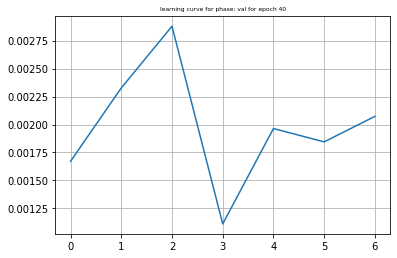

val Loss: 0.0020 
####################################################


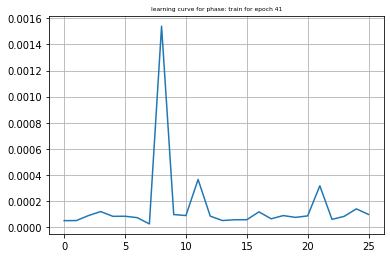

train Loss: 0.0002 
####################################################


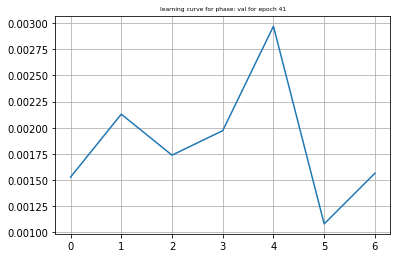

val Loss: 0.0019 
####################################################


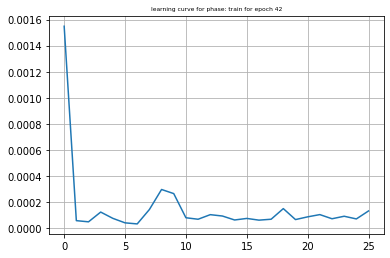

train Loss: 0.0002 
####################################################


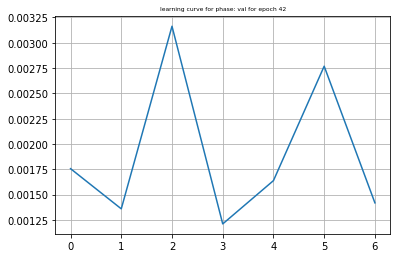

val Loss: 0.0020 
####################################################


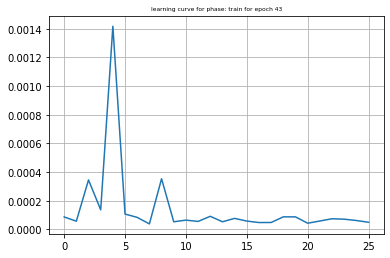

train Loss: 0.0001 
####################################################


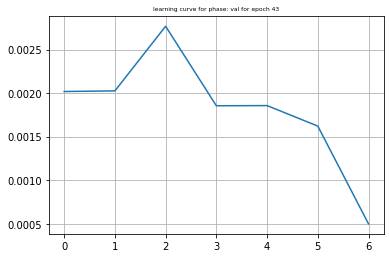

val Loss: 0.0019 
####################################################


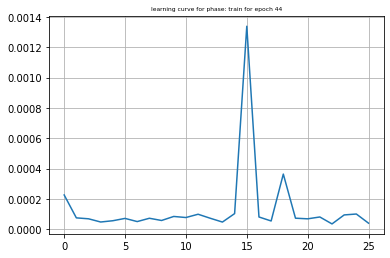

train Loss: 0.0001 
####################################################


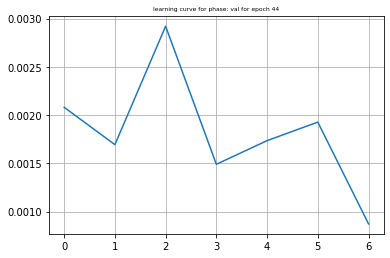

val Loss: 0.0019 
####################################################


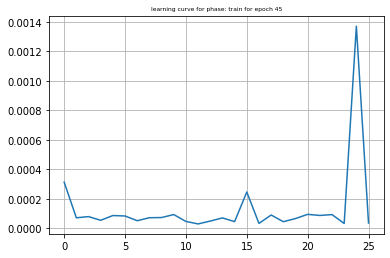

train Loss: 0.0001 
####################################################


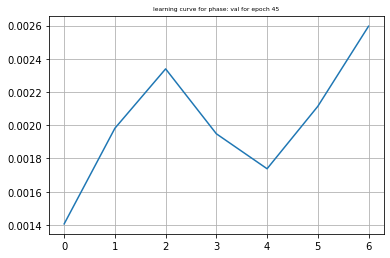

val Loss: 0.0020 
####################################################


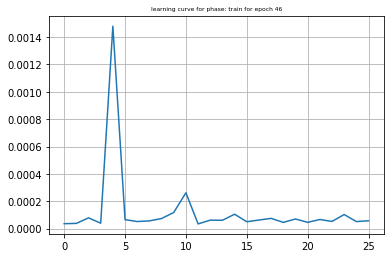

train Loss: 0.0001 
####################################################


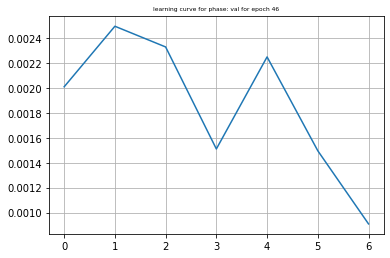

val Loss: 0.0020 
####################################################


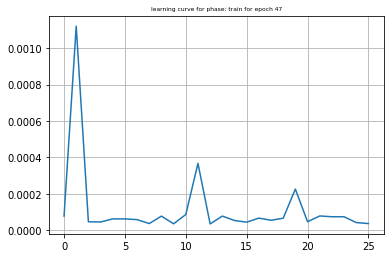

train Loss: 0.0001 
####################################################


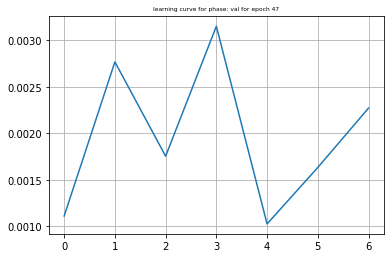

val Loss: 0.0019 
####################################################


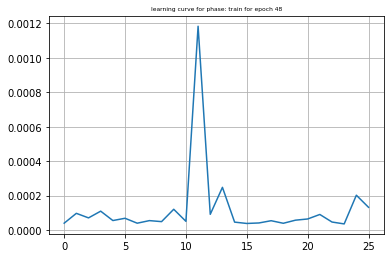

train Loss: 0.0001 
####################################################


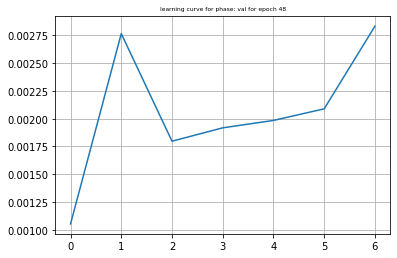

val Loss: 0.0020 
####################################################


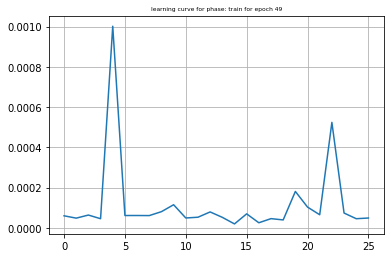

train Loss: 0.0001 
####################################################


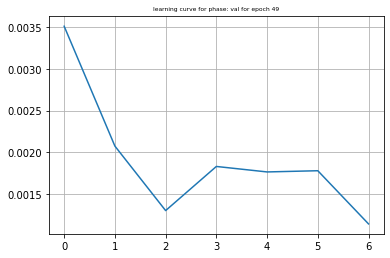

val Loss: 0.0020 
####################################################


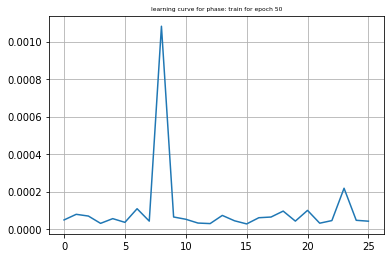

train Loss: 0.0001 
####################################################


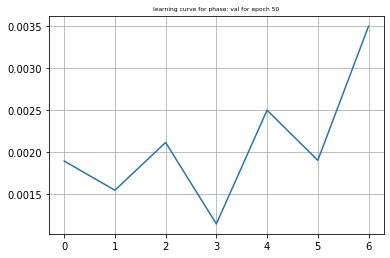

val Loss: 0.0019 
####################################################


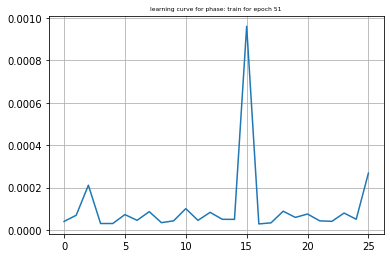

train Loss: 0.0001 
####################################################


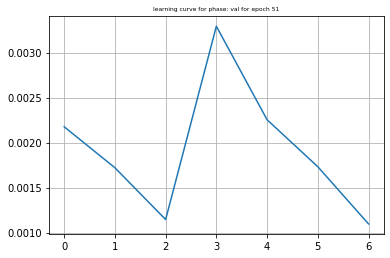

val Loss: 0.0020 
####################################################


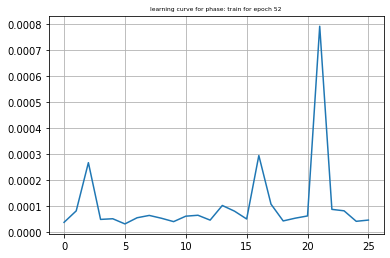

train Loss: 0.0001 
####################################################


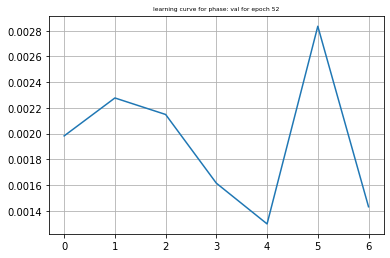

val Loss: 0.0020 
####################################################


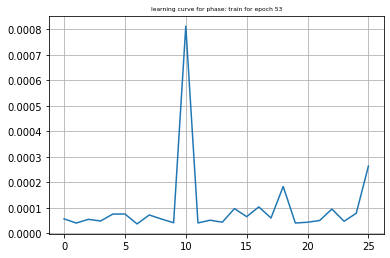

train Loss: 0.0001 
####################################################


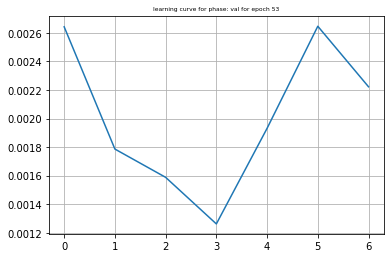

val Loss: 0.0020 
####################################################


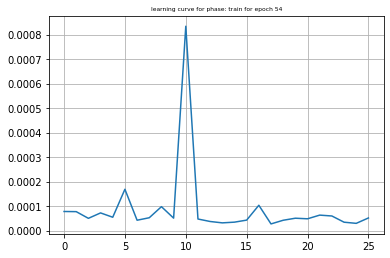

train Loss: 0.0001 
####################################################


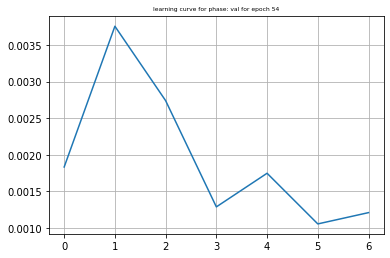

val Loss: 0.0020 
####################################################


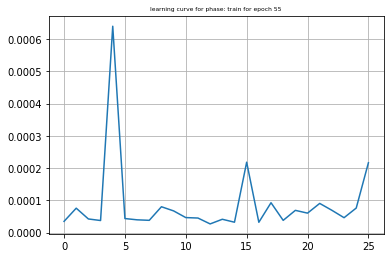

train Loss: 0.0001 
####################################################


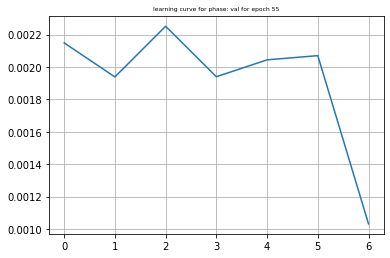

val Loss: 0.0020 
####################################################


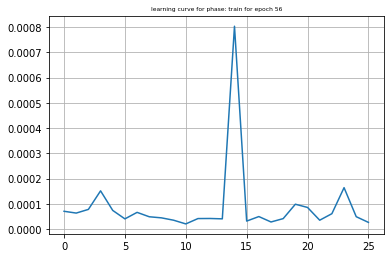

train Loss: 0.0001 
####################################################


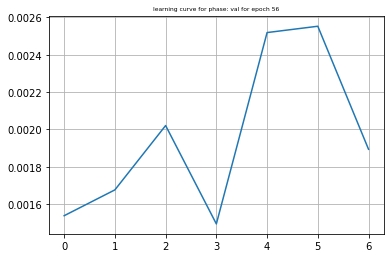

val Loss: 0.0020 
####################################################


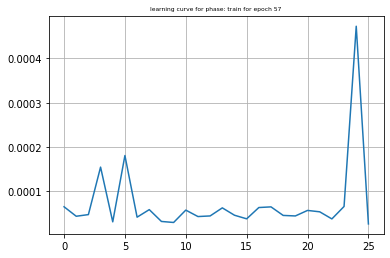

train Loss: 0.0001 
####################################################


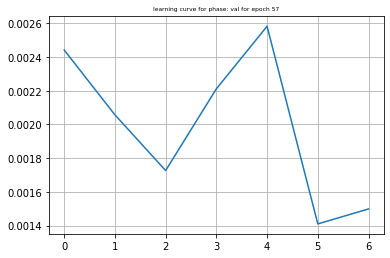

val Loss: 0.0020 
####################################################


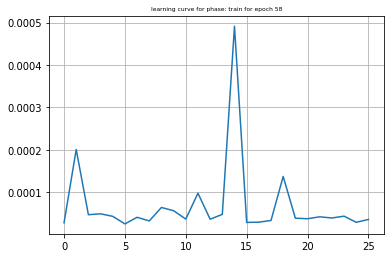

train Loss: 0.0001 
####################################################


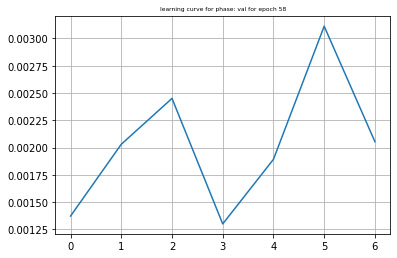

val Loss: 0.0020 
####################################################


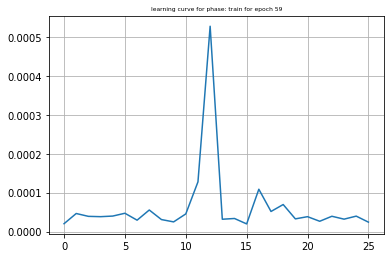

train Loss: 0.0001 
####################################################


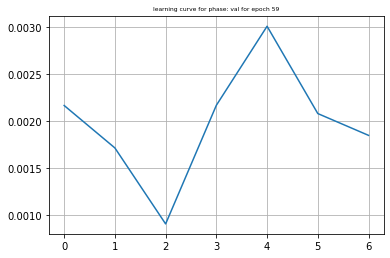

val Loss: 0.0020 
####################################################


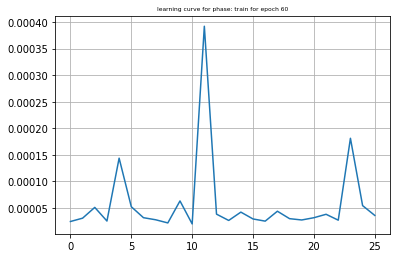

train Loss: 0.0001 
####################################################


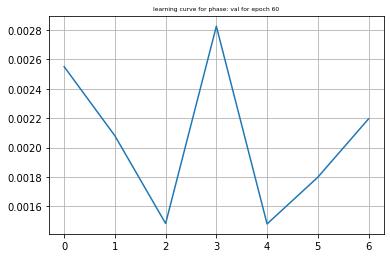

val Loss: 0.0020 
####################################################


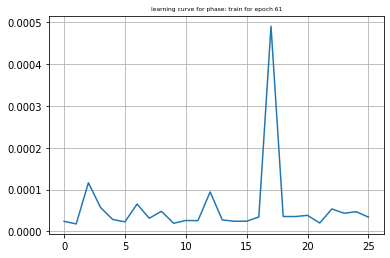

train Loss: 0.0001 
####################################################


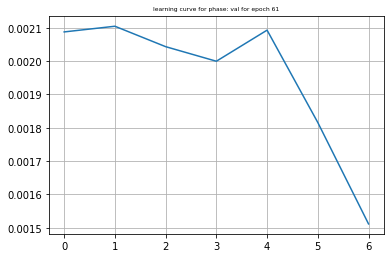

val Loss: 0.0020 
####################################################


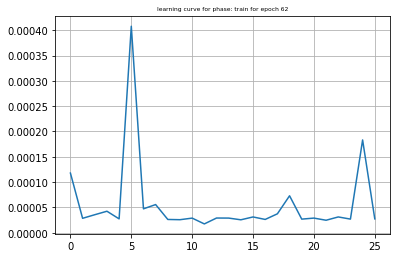

train Loss: 0.0001 
####################################################


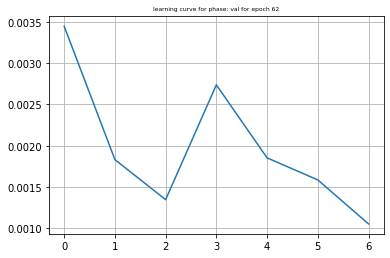

val Loss: 0.0021 
####################################################


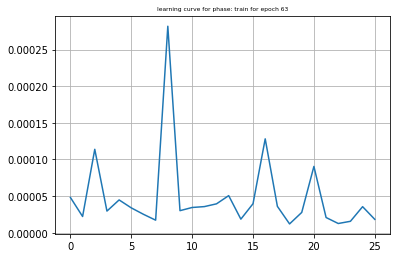

train Loss: 0.0000 
####################################################


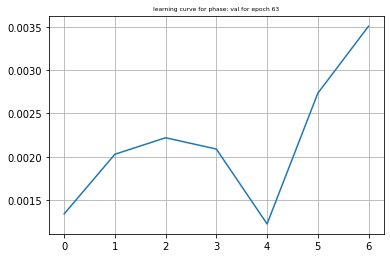

val Loss: 0.0020 
####################################################


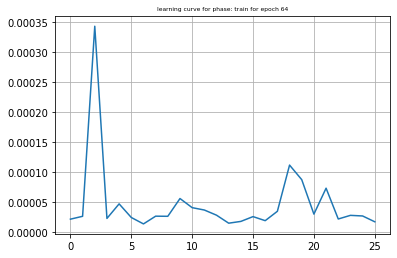

train Loss: 0.0000 
####################################################


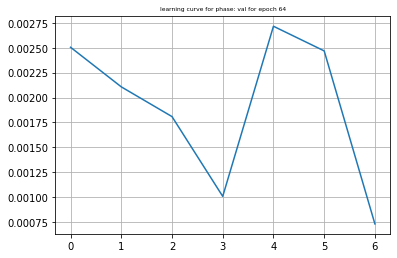

val Loss: 0.0020 
####################################################


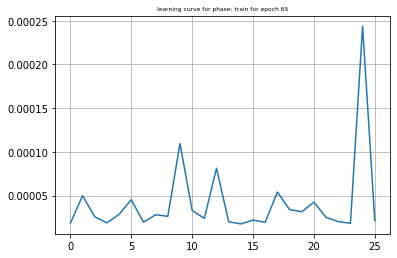

train Loss: 0.0000 
####################################################


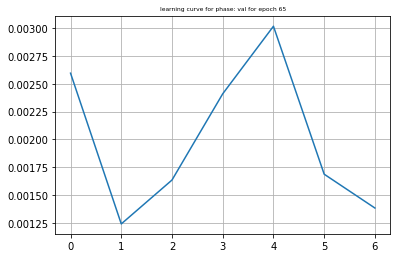

val Loss: 0.0021 
####################################################


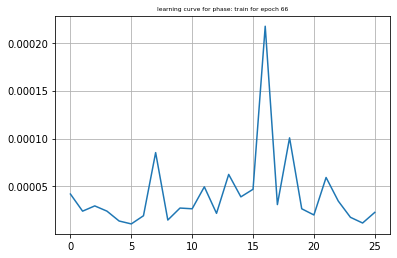

train Loss: 0.0000 
####################################################


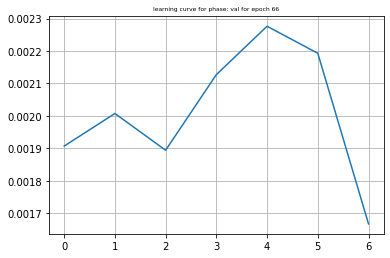

val Loss: 0.0020 
####################################################


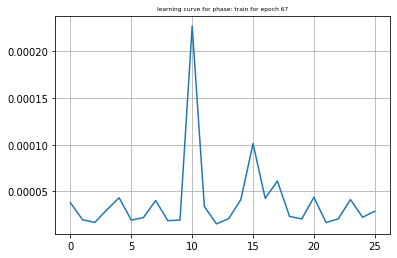

train Loss: 0.0000 
####################################################


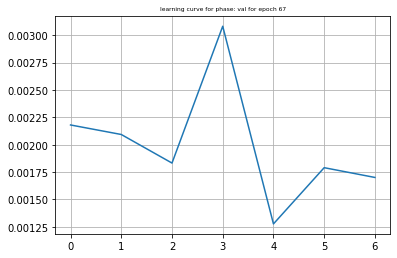

val Loss: 0.0020 
####################################################


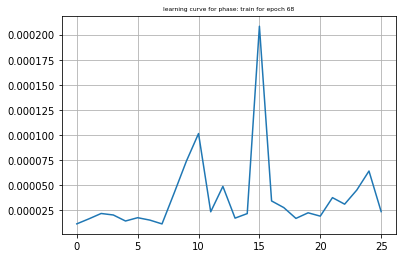

train Loss: 0.0000 
####################################################


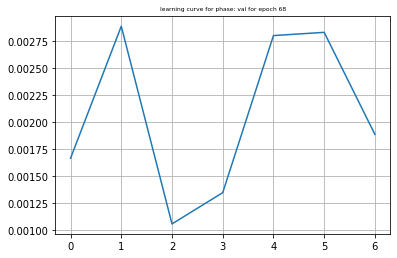

val Loss: 0.0021 
####################################################


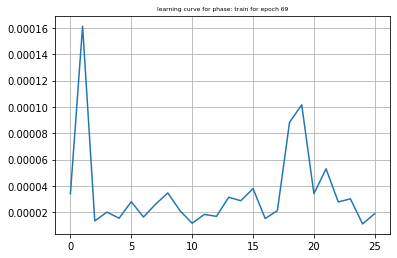

train Loss: 0.0000 
####################################################


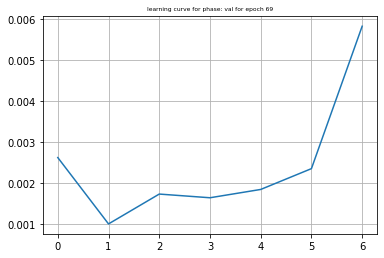

val Loss: 0.0021 
####################################################


In [44]:
model = train_model(in_art_model,
                    criterion, 
                    optimizer, 
                    epoch=70, 
                    dataloaders=dataloaders,
                    dataset_sizes=dataset_sizes,
                    model_name = f'/content/drive/MyDrive/ТМСС/models/illNet2')